# 3Day subsampling on the OceanColor Dataset

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# resampling frequency in number of days
freq=3

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [3]:
ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [4]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [5]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [6]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [7]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [8]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


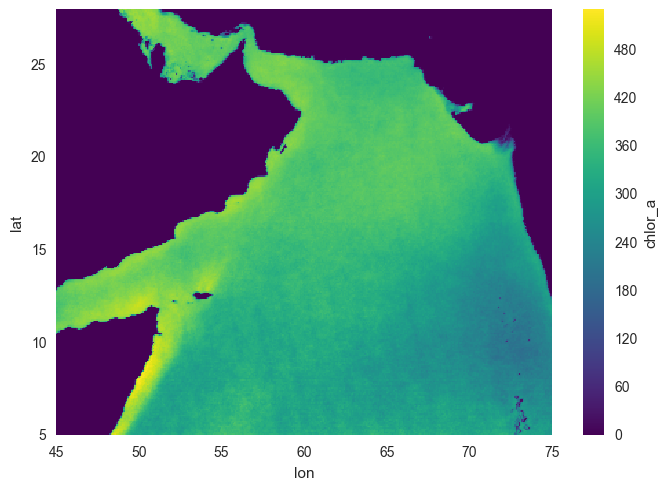

In [9]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


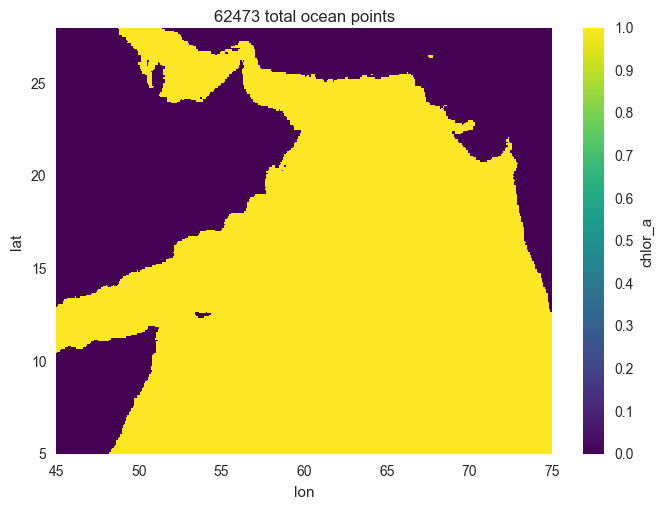

In [10]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [11]:
#ds_8day

In [12]:
#ds_daily

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


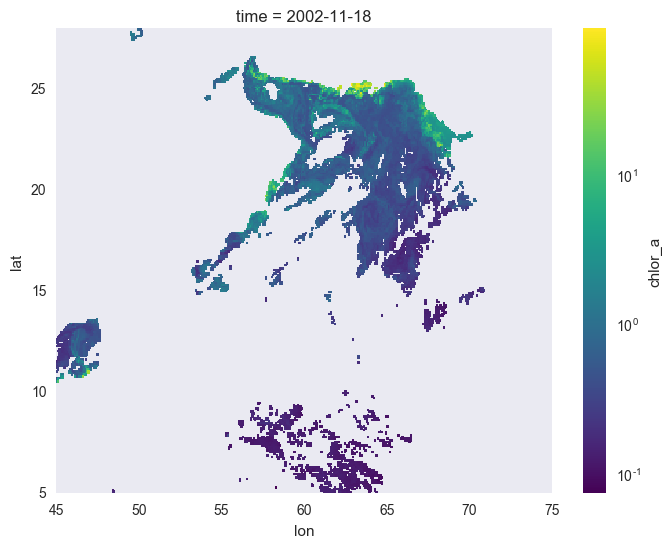

In [13]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [14]:
#list(ds_daily.groupby('time')) # take a look at what's inside

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [15]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...

In [16]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [17]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

In [18]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


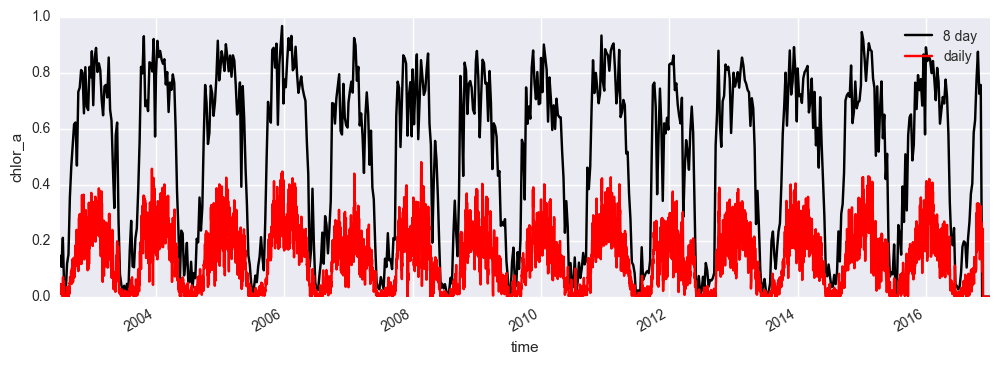

In [19]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

## Seasonal Climatology

In [20]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

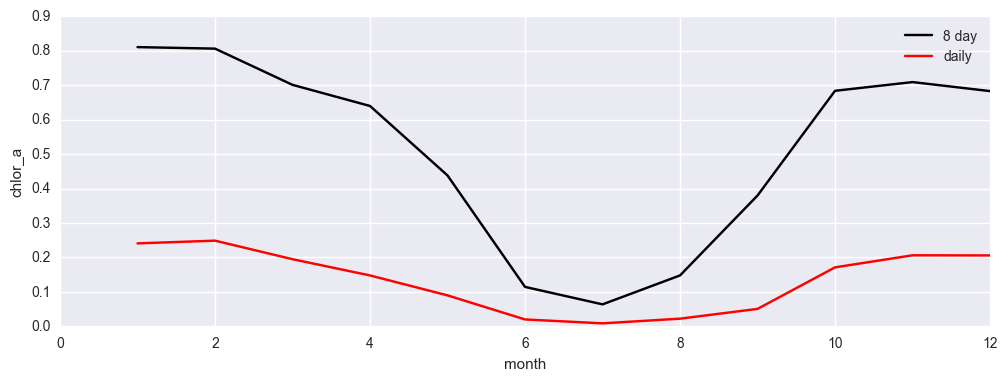

In [21]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


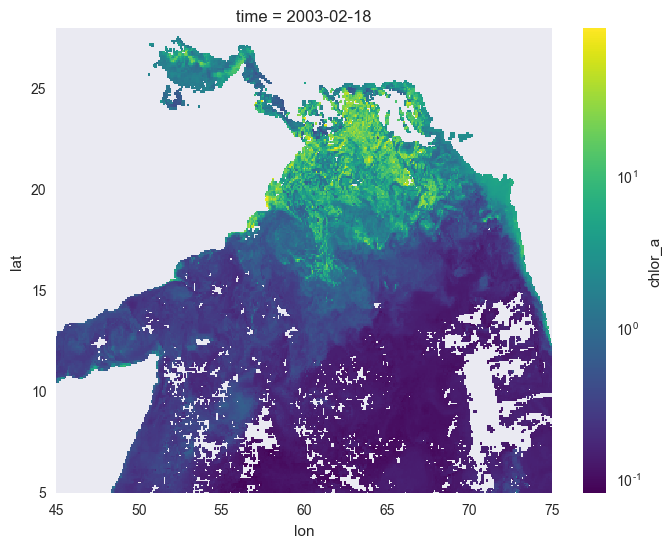

In [22]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


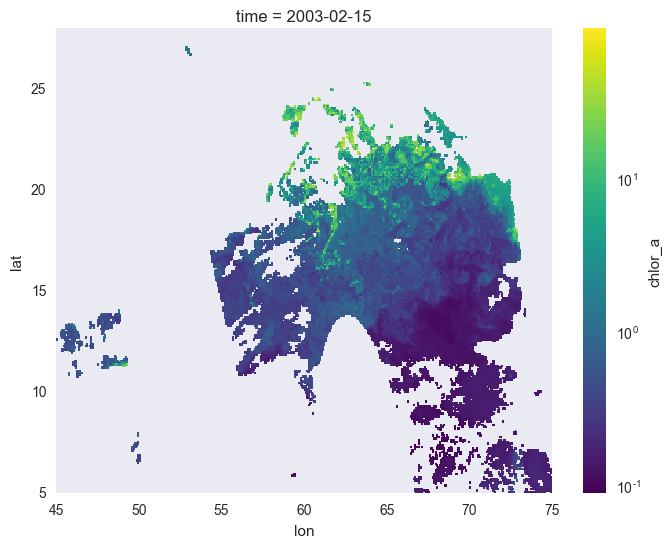

In [23]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [24]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lat      (points) float64 16.04 18.04
    lon      (points) float64 65.04 70.04
  * points   (points) int64 0 1

In [25]:
df = pd.DataFrame([[1.4, np.nan], [7.1, -4.5], [np.nan, np.nan], [0.75, -1.3]], 
               index=['a', 'b', 'c', 'd'], columns=['one', 'two'])
df.mean(axis=1,skipna=None) # try skipna=False, skipna=True(seems to equiv to skipna=None)

a    1.400
b    1.300
c      NaN
d   -0.275
dtype: float64

In [26]:
freq_resample = str(freq) + 'D'
print("resampling frequency is ", freq_resample)
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

resampling frequency is  3D


<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 1765)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-07 2002-07-10 ...
Data variables:
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


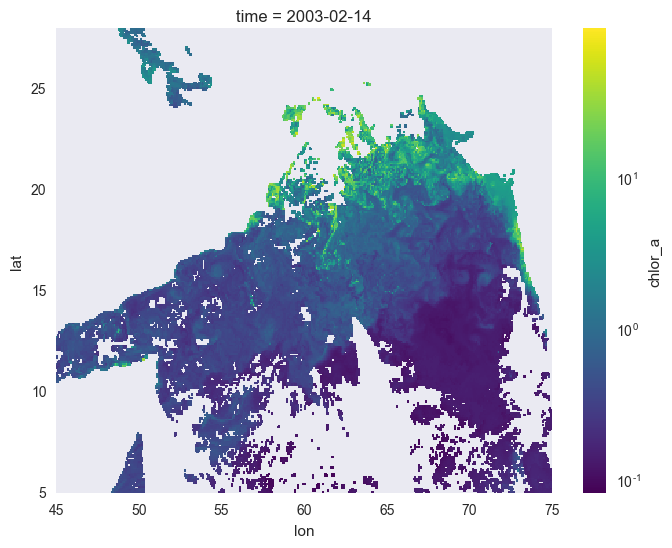

In [27]:
plt.figure(figsize=(8,6))
ds_resample.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [28]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [29]:
# in the following we deal with the data from the gdp float
from buyodata import buoydata
import os

In [30]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [31]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for chlor_a
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

0

In [32]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


id           lat           lon          temp            ve  \
count  2.147732e+07  2.131997e+07  2.131997e+07  1.986179e+07  2.129142e+07   
mean   1.765662e+06 -2.263128e+00  2.124412e+02  1.986121e+01  2.454172e-01   
std    9.452835e+06  3.401115e+01  9.746941e+01  8.339498e+00  2.525050e+01   
min    2.578000e+03 -7.764700e+01  0.000000e+00 -1.685000e+01 -2.916220e+02   
25%    4.897500e+04 -3.186000e+01  1.490720e+02  1.437300e+01 -1.411400e+01   
50%    7.141300e+04 -4.920000e+00  2.153940e+02  2.214400e+01 -5.560000e-01   
75%    1.094330e+05  2.756000e+01  3.064370e+02  2.688900e+01  1.356100e+01   
max    6.399288e+07  8.989900e+01  3.600000e+02  4.595000e+01  4.417070e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  2.129142e+07  2.129142e+07  2.147732e+07  2.147732e+07  2.147732e+07  
mean   4.708192e-01  2.613427e+01  7.326258e+00  7.326555e+00  7.522298e+01  
std    2.052160e+01  1.939087e+01  8.527853e+01  8.527851e+01  2.637454e+02  
min   -2.601400e+02  0.000000e+00  5.268300e-07 -3.941600e-02  1.001300e-03  
25%   -1.044700e+01  1.290300e+01  4.366500e-06  7.512600e-06  1.435700e-03  
50%    1.970000e-01  2.176700e+01  8.833600e-06  1.495800e-05  1.691700e-03  
75%    1.109300e+01  3.405900e+01  1.833300e-05  3.627900e-05  2.294200e-03  
max    2.783220e+02  4.421750e+02  1.000000e+03  1.000000e+03  1.000000e+03

In [33]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


In [34]:
''' takes took long
# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)
'''

'''
# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)
'''

"\n# visualize the float around the arabian sea region\nfig, ax  = plt.subplots(figsize=(12,10))\nfloatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)\n"

In [35]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [36]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [37]:
floatsDSAll.dims

Frozen(SortedKeysDict({'time': 17499, 'id': 259}))

In [38]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_resample =floatsDSAll.resample(freq_resample, dim='time')
print(floatsDSAll_resample.dims)   # downsampling on the 'time' dimension 17499/9/4=  around 486
floatsDSAll_resample

Frozen(SortedKeysDict(OrderedDict([('id', 259), ('time', 1704)])))


<xarray.Dataset>
Dimensions:  (id: 259, time: 1704)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-07 2002-07-10 ...
Data variables:
    lon      (time, id) float64 nan 66.38 69.59 64.73 69.62 nan 68.84 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003607 0.07764 nan ...
    spd      (time, id) float64 nan 12.92 21.86 14.67 21.2 nan 27.52 nan ...
    vn       (time, id) float64 nan -6.362 -19.1 -7.017 -18.71 nan 4.231 nan ...
    lat      (time, id) float64 nan 16.21 13.82 16.33 13.83 nan 20.18 nan ...
    ve       (time, id) float64 nan 10.94 9.9 12.24 9.378 nan 26.28 nan ...
    temp     (time, id) float64 nan nan nan 27.92 28.56 nan 28.97 nan 27.66 ...
    var_lon  (time, id) float64 nan 0.006395 9.575e-05 0.0001482 9.875e-05 ...
    var_lat  (time, id) float64 nan 0.001675 5.309e-05 7.571e-05 5.407e-05 ...

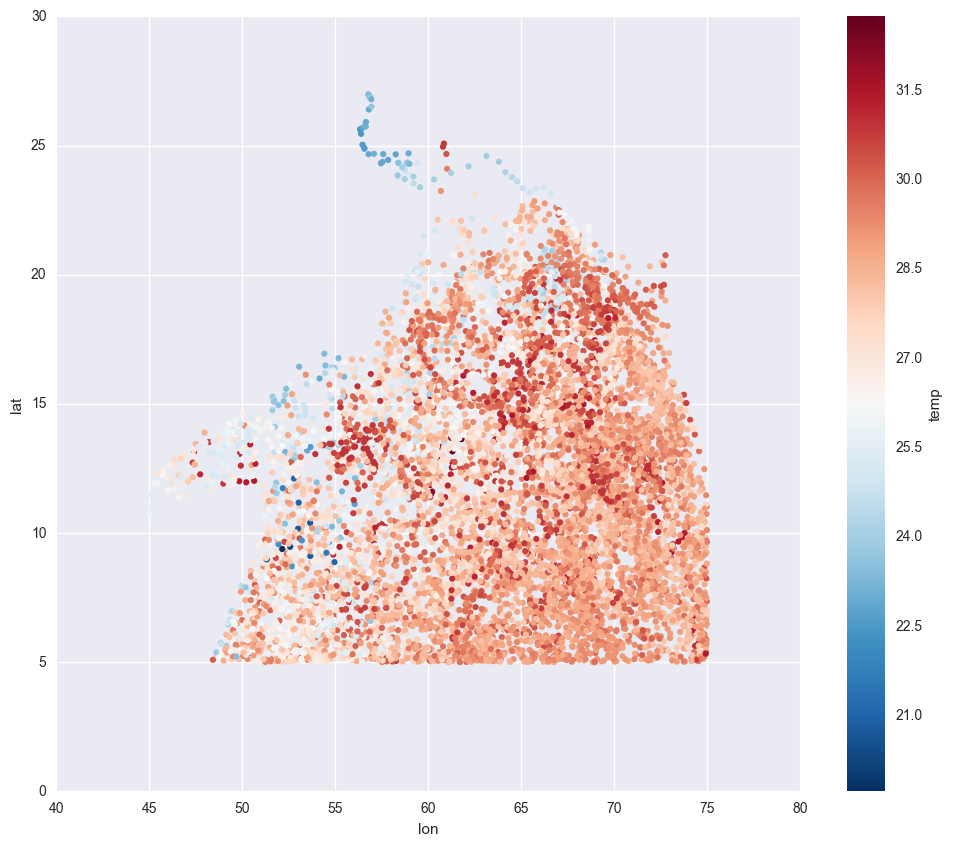

In [39]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_resample = floatsDSAll_resample.to_dataframe()
floatsDFAll_resample
floatsDFAll_resample = floatsDFAll_resample.reset_index()
floatsDFAll_resample
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [40]:
# get the value for the chlorophyll for each data entry
floatsDFAll_resample_timeorder = floatsDFAll_resample.sort_values(['time','id'],ascending=True)
floatsDFAll_resample_timeorder[:20] # check whether it is time ordered!!
# should we drop nan to speed up??

id       time        lon      var_tmp        spd         vn  \
0       7574 2002-07-04        NaN          NaN        NaN        NaN   
1704   10206 2002-07-04  66.375833  1000.000000  12.924000  -6.362417   
3408   10208 2002-07-04  69.589833  1000.000000  21.864250 -19.104583   
5112   11089 2002-07-04  64.731500     0.003607  14.670833  -7.016583   
6816   15703 2002-07-04  69.617667     0.077642  21.204917 -18.706167   
8520   15707 2002-07-04        NaN          NaN        NaN        NaN   
10224  27069 2002-07-04  68.844083     0.001681  27.516167   4.231083   
11928  27139 2002-07-04        NaN          NaN        NaN        NaN   
13632  28842 2002-07-04  60.748083     0.003285  24.501167  -5.116833   
15336  34159 2002-07-04  59.009333  1000.000000  26.245667   5.826667   
17040  34173 2002-07-04        NaN          NaN        NaN        NaN   
18744  34210 2002-07-04  56.899000     0.003603  19.873667 -16.234583   
20448  34211 2002-07-04  68.015250     0.003496  26.681000 -15.920167   
22152  34212 2002-07-04  64.844583     0.003571  32.034083  18.941000   
23856  34223 2002-07-04        NaN          NaN        NaN        NaN   
25560  34310 2002-07-04        NaN          NaN        NaN        NaN   
27264  34311 2002-07-04        NaN          NaN        NaN        NaN   
28968  34312 2002-07-04        NaN          NaN        NaN        NaN   
30672  34314 2002-07-04        NaN          NaN        NaN        NaN   
32376  34315 2002-07-04        NaN          NaN        NaN        NaN   

             lat         ve       temp   var_lon   var_lat  
0            NaN        NaN        NaN       NaN       NaN  
1704   16.208333  10.941333        NaN  0.006395  0.001675  
3408   13.816917   9.899750        NaN  0.000096  0.000053  
5112   16.331167  12.239583  27.917667  0.000148  0.000076  
6816   13.829750   9.378000  28.555167  0.000099  0.000054  
8520         NaN        NaN        NaN       NaN       NaN  
10224  20.177000  26.284000  28.973000  0.000107  0.000058  
11928        NaN        NaN        NaN       NaN       NaN  
13632  18.852000  11.585000  27.663833  0.000225  0.000106  
15336  12.568250  25.174250        NaN  0.000109  0.000058  
17040        NaN        NaN        NaN       NaN       NaN  
18744   6.409500  -9.563583  26.715250  0.000146  0.000072  
20448   8.539083  20.941750  28.316167  0.000098  0.000054  
22152   6.327167  23.924750  28.476000  0.000096  0.000053  
23856        NaN        NaN        NaN       NaN       NaN  
25560        NaN        NaN        NaN       NaN       NaN  
27264        NaN        NaN        NaN       NaN       NaN  
28968        NaN        NaN        NaN       NaN       NaN  
30672        NaN        NaN        NaN       NaN       NaN  
32376        NaN        NaN        NaN       NaN       NaN

In [41]:
'''
<xarray.Dataset>
Dimensions:  (id: 259, time: 639)   # 259*639
'''
floatsDFAll_resample_timeorder.lon.shape

(441336,)

In [42]:
# can we try to fit the missing value at thisstep
floatsDFAll_resample_timeorder.lon.dropna().shape  # the longitude data has lots of values (3855,)

(9689,)

In [43]:
############ interpolation starts from here

           id       time  lon  var_tmp  spd  vn  lat  ve  temp  var_lon  \
170400  62558 2002-07-04  NaN      NaN  NaN NaN  NaN NaN   NaN      NaN   
172104  63036 2002-07-04  NaN      NaN  NaN NaN  NaN NaN   NaN      NaN   
173808  63067 2002-07-04  NaN      NaN  NaN NaN  NaN NaN   NaN      NaN   
175512  63068 2002-07-04  NaN      NaN  NaN NaN  NaN NaN   NaN      NaN   
177216  63069 2002-07-04  NaN      NaN  NaN NaN  NaN NaN   NaN      NaN   

        var_lat  
170400      NaN  
172104      NaN  
173808      NaN  
175512      NaN  
177216      NaN  


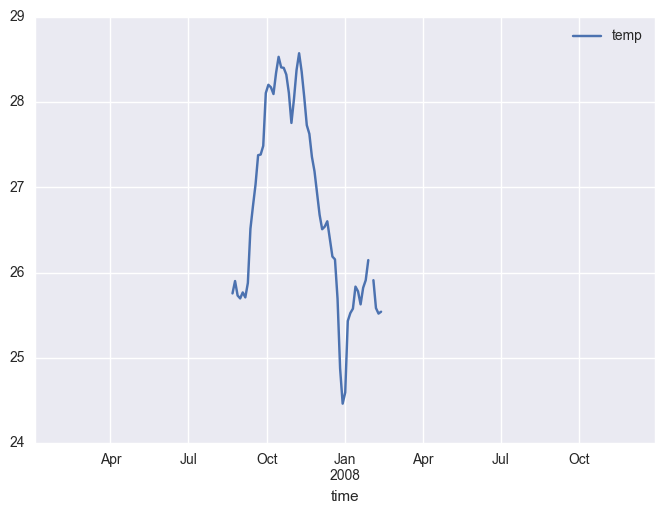

In [44]:
# to understand the float data better
# a: Look into the floatsDFAll_9Dtimeorder data in more details
# check the nan counts in each id
# plot the trajectory of {time, lat, lon, temperature,} for each float id,  
# this steps helps to understand the float dataset and if there is a need, improve it.

# b: take the float data as it is, and do the interpolation, whenever there is a nan value use the nearest neigbhours....
# check whether the quality of interpolataion is improved, if not, then have to fall back to to task 1

# c: vectorization

# DataFrame panel data 
# floatsDFAll_9Dtimeorder.set_index(['id','time']) 
# the inverse operation # floatsDFAll_9Dtimeorder.reset_index()
# look into the data
print(floatsDFAll_resample_timeorder[100:105])
# so far there is no need to convert it into a panel 
# floatsDFAll_9DtimeorderPanel = floatsDFAll_9Dtimeorder.to_panel

# plot the temperature for one float, the temperature do have a trend
maskid = (floatsDFAll_resample_timeorder.id == 63069) & (floatsDFAll_resample_timeorder.time> '2007-01-01') & (floatsDFAll_resample_timeorder.time< '2009-01-01')
floatsDFAll_resample_timeorder[maskid]
floatsDFAll_resample_timeorder[maskid].plot(x='time', y ='temp')

In [45]:
# this is a float that explains the need for temperature data
maskid2 = floatsDFAll_resample_timeorder.id == 10208
floatsDFAll_resample_timeorder[maskid2].head()

id       time        lon  var_tmp        spd         vn        lat  \
3408  10208 2002-07-04  69.589833   1000.0  21.864250 -19.104583  13.816917   
3409  10208 2002-07-07  69.884583   1000.0  17.390500  -5.675667  13.513167   
3410  10208 2002-07-10  70.268000   1000.0  14.501167  -0.032583  13.468417   
3411  10208 2002-07-13  70.522750   1000.0  10.286250  -0.744083  13.473333   
3412  10208 2002-07-16  70.710917   1000.0  10.992667  -0.871167  13.476333   

             ve  temp   var_lon   var_lat  
3408   9.899750   NaN  0.000096  0.000053  
3409  15.487750   NaN  0.000146  0.000073  
3410  13.440667   NaN  0.000106  0.000058  
3411   9.204417   NaN  0.000131  0.000068  
3412   8.833917   NaN  0.000113  0.000061

In [46]:
################
# test case 1: take a single entry (southeast corner for valid values)
row_case1 =  pd.DataFrame(data = {'time':'2002-07-13 00:00:00', 'id': 10206, 'lon':74.7083358765, 'lat':5.20833349228},index=[1])
print(row_case1)

################
# test case 2
# take a {time-list, id-list, lon-list, lat-list}, index-list 
# carry out the interpolation
#row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00','2002-07-22 00:00:00'] , 'id': [10206, 10206], 'lon':[74.7083358765, 74.6250076294], 'lat':[5.20833349228, 5.29166173935]},index=[2,3])
#print(row_case2)
################
# test case 3
row_case2 =  pd.DataFrame(data = {'time':['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00'] , 'id': [10206, 10206, 10206], 'lon':[74.7083358765, 74.6250076294,74.7083358765], 'lat':[5.20833349228, 5.29166173935, 5.20833349228]},index=[1,2,3])
print(row_case2)



####
## get the indices of time, lat, lon
idx_time = ds_resample.indexes['time']
idx_lat = ds_resample.indexes['lat']
idx_lon = ds_resample.indexes['lon']

#### 
#interpolation on the time dimension
time_len = len(row_case2.time.values)
xtime_test = list([ np.datetime64(row_case2.time.values[i]) for i in range(0,time_len)  ] )  # for delta 
print('\n xtime_test \n', xtime_test)

'''caution: cannot do this inside the function get_loc,
see https://github.com/pandas-dev/pandas/issues/3488
'''
itime_nearest = [idx_time.get_loc(xtime_test[i], method='nearest') for i in range(0, time_len)]
print('\n itime_nearest \n', itime_nearest)  # [1,2]

xtime_nearest =  ds_resample.time[itime_nearest].values  #  ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('\n xtime_nearest\n', xtime_nearest)  # ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000']
print('xtime_nearest', type(xtime_nearest)) # xtime_nearest <class 'numpy.ndarray'> # time_nearest <class 'numpy.datetime64'>

# the time distance in days
delta_xtime = (xtime_test - xtime_nearest) / np.timedelta64(1, 'D')
print('\n delta_xtime in days \n', delta_xtime)
print(type(delta_xtime))

itime_next = [itime_nearest[i]+1 if  delta_xtime[i] >=0  else itime_nearest[i]-1  for i in range(0, time_len) ]
print('\n itime_next \n',itime_next)  # [2, 3]

# find the next coordinate values
xtime_next = ds_resample.time[itime_next].values
print('\n xtime_next \n', xtime_next) # ['2002-07-22T00:00:00.000000000' '2002-07-31T00:00:00.000000000']

# prepare for the Tri-linear interpolation
base_time = (xtime_next - xtime_nearest) / np.timedelta64(1, 'D')  # [ 9.  9.]
print('\n base_time \n', base_time)
w_time = delta_xtime / base_time  
print('\n w_time \n', w_time) # [ 0.  0.]


#### 
#interpolation on the lat dimension
xlat_test = row_case2.lat.values + 0.06   # base [ 5.20833349  5.29166174] # cell distance around .8, use .2 & .6 as two tests
print('\n xlat_test \n', xlat_test)       # xlat_test [ 5.26833349  5.35166174]

ilat_nearest = [idx_lat.get_loc(xlat_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilat_nearest \n', ilat_nearest) # [272, 271]

xlat_nearest = ds_resample.lat[ilat_nearest].values  
print('\n xlat_nearest \n', xlat_nearest) # [ 5.29166174  5.37499762]

delta_xlat = xlat_test - xlat_nearest
print("\n delta_xlat \n",delta_xlat)      #  [-0.02332825 -0.02333588]


# the nearest index is on the right; but order of the latitude is different, it is descending
ilat_next = [ilat_nearest[i]-1 if  delta_xlat[i] >=0  else ilat_nearest[i]+1  for i in range(0, time_len) ]
print('\n ilat_next \n', ilat_next)  # [273, 272]

# find the next coordinates value
xlat_next = ds_resample.lat[ilat_next].values
print('\n xlat_next \n', xlat_next)  # [ 5.20833349  5.29166174]

# prepare for the Tri-linear interpolation
w_lat = delta_xlat / (xlat_next - xlat_nearest)
print('\n w_lat \n', w_lat) # [ 0.27995605  0.28002197]

#### 
#interpolation on the lon dimension
xlon_test = row_case2.lon.values +0.06 # base [74.7083358765, 74.6250076294] # cell distance around .8, use .2 & .6 as two tests
print('\n xlon_test \n', xlon_test)  # [ 74.76833588  74.68500763]

ilon_nearest = [idx_lon.get_loc(xlon_test[i], method='nearest') for i in range(0, time_len)]
print('\n ilon_nearest \n', ilon_nearest) # [357, 356]

xlon_nearest = ds_resample.lon[ilon_nearest].values  
print('\n xlon_nearest \n', xlon_nearest) # [ 74.79166412  74.70833588]

delta_xlon = xlon_test - xlon_nearest     
print("\n delta_xlon \n", delta_xlon)     #  [-0.02332825 -0.02332825]

ilon_next = [ilon_nearest[i]+1 if  delta_xlon[i] >=0  else ilon_nearest[i]-1  for i in range(0, time_len) ]
print('\n ilon_next \n',ilon_next)  # [356, 355]

# find the next coordinate values
xlon_next = ds_resample.lon[ilon_next].values
print("\n xlon_next \n", xlon_next) # [ 74.70833588  74.62500763]

# prepare for the Tri-linear interpolation
w_lon = delta_xlon / (xlon_next - xlon_nearest)
print("\n w_lon \n", w_lon) # [ 0.27995605  0.27995605]

####
# local Tensor product for Trilinear interpolation
# caution: nan values, store as "list_of_array to 2d_array" first, then sum

# no casting to list needed here, inputs are already lists
tmp = np.array([
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_nearest, lat=ilat_next, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_nearest, lon=ilon_next).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_nearest).values,
         ds_resample.chlor_a.isel_points(time=itime_next, lat=ilat_next, lon=ilon_next).values ])

weights =  np.array([(1-w_time)*(1-w_lat)*(1-w_lon), 
                     (1-w_time)*(1-w_lat)*w_lon,
                     (1-w_time)*w_lat*(1-w_lon), 
                     (1-w_time)*w_lat*w_lon,
                        w_time*(1-w_lat)*(1-w_lon),
                        w_time*(1-w_lat)*w_lon,
                        w_time*w_lat*(1-w_lon),
                        w_time*w_lat*w_lon ])


# how to deal with "nan" values, fill in missing values for the np.array tmpAll 
# or fill the mean values to the unweighted array
# http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

print('\n neighbouring tensor used \n', tmp)
'''
 neighbouring tensor used 
 [[        nan  0.181841  ]
 [ 0.245878           nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.19680101         nan]
 [        nan         nan]
 [        nan         nan]
 [ 0.18532801         nan]]
'''

# column min: (nan+0.245878 + nan + nan + 0.19680101 + nan +  nan + 0.18532801)/8 = 0.20933567333
col_mean = np.nanmean(tmp, axis=0)
print('\n its mean along axis 0(column) \n', col_mean)  #  [ 0.20933567  0.181841  ]


# filling the missing values.
inds = np.where(np.isnan(tmp))
print('\n nan index\n', inds)
tmp[inds]=np.take(col_mean, inds[1])
print('\n values after the fill \n', tmp)

print('\n weighting tensor used \n', weights)

print("weights.shape", weights.shape) # (8, 3)
print("tmp.shape", tmp.shape)  # (8, 3)

nrow_w, ncol_w = weights.shape
nrow_t, ncol_t = tmp.shape
assert nrow_w == nrow_t, "the row count of weights and values are not the same!"
assert ncol_w == ncol_t, "the row count of weights and values are not the same!"
print('\n tensor product\n', np.dot(weights[:,0], tmp[:,0]) ) # 0.216701896135 should be [ 0.2167019]

# new interpolation process of the Chl_a
chl_new = np.empty(ncol_w)
for i in range(0, ncol_w, 1):
    chl_new[i] =  np.dot(weights[:,i], tmp[:,i])

print('chl_newInt',  chl_new) #  [ 0.2167019  0.181841   0.2167019]
# validate by 1D array
# val = np.array([0.20933567, 0.245878,  0.20933567,
#                0.20933567, 0.19680101, 0.20933567,
#               0.20933567,0.18532801]) 
# np.dot(val, weights) # 0.21670189702309739


## output xarray.dataarray of points, see examples below
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['points'], np.random.randn(3))},
                        coords={
                                'time':(['points'],['2002-07-13 00:00:00', '2002-07-22 00:00:00', '2002-07-13 00:00:00']) , 
                                'id': (['points'], [10206, 10206, 10206]), 
                                'lon': (['points'], [74.7083358765, 74.6250076294,74.7083358765]),
                                'lat':(['points'], [5.20833349228, 5.29166173935, 5.20833349228]), 
                                'points': (['points'], [0,1,2])}) # this way the dims is set to point

print('\n',chl_newInt.chl)
'''
### Task: output xarray.dataarray as points
## example 1
arr = xr.DataArray(np.random.rand(4,3), [('time', pd.date_range('2000-01-01', periods=4)), ('space', ['IA', 'IL', 'IN'])] )
print("first example",arr)
print("\n \n")

## example2 -- concrete xr.DataArray
data = np.random.rand(4, 3)
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
brr = xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, \
                          'ranking': ('space', [1, 2, 3])}, \
             dims=['time', 'space'])
print("second example",brr)
'''

'''
### the target output
#the output generated by the xarray.DataSet => xarray.DataArray
<xarray.DataArray 'chlor_a' (points: 147112)>
array([ nan,  nan,  nan, ...,  nan,  nan,  nan])
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    lon      (points) float64 74.96 66.54 69.88 65.04 69.88 74.96 69.46 ...
    lat      (points) float64 27.96 16.21 13.62 16.04 13.62 27.96 20.04 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  
### the solution approach we tried to is: first,  generate a xarray.DataSet
                                          second, generte a xarray.DataArray from the xarray DataSet if needed.
 
# 1. looking at this example, DataArray seems to be working.

# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

##########
# but not works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  np.array([10206, 10206, 10206])} )
print('\n da_test1', da_test1)

# err's
##########

##########
# works here
da_test1 = xr.DataArray(np.random.rand(3), dims=['x'],
                        coords={'x': np.array([10206, 10206, 10206]), 'y':  2} )
print('\n da_test1', da_test1)

# da_test1 <xarray.DataArray (x: 3)>
# array([ 0.90386212,  0.21516239,  0.44707272])
# Coordinates:
#   * x        (x) int64 10206 10206 10206
#     y        int64 2
##########

##########
# so we do this
# this is the way how xarray.Dataset works
# if you want a xarray.DataArray, first generate a xarray.Dataset, then select DataArray from there.
chl_newInt = xr.Dataset({'chl': (['id'], np.random.randn(3))},
                        coords={ 
                           'id':  (['id'], np.array([10206, 10206, 10206])), 
                           'lon': (['id'], np.array([74.7083358765, 74.6250076294,74.7083358765])), 
                           'lat': (['id'], np.array([5.20833349228, 5.29166173935, 5.20833349228]))})
print('chl_newInt', chl_newInt) # generate the xarray.DataSet
print('\n \n')
print('chl_newInt.chl', chl_newInt.chl) # xarray.DataSet contains many xarray.DataArray


#chl_newInt <xarray.Dataset>
#Dimensions:  (id: 3)
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208
#Data variables:
#    chl      (id) float64 0.783 -0.9714 -0.3206



#chl_newInt.chl <xarray.DataArray 'chl' (id: 3)>
#array([ 0.78301614, -0.97144208, -0.3206447 ])
#Coordinates:
#    lon      (id) float64 74.71 74.63 74.71
#  * id       (id) int64 10206 10206 10206
#    lat      (id) float64 5.208 5.292 5.208

'''
print()

      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
      id       lat        lon                 time
1  10206  5.208333  74.708336  2002-07-13 00:00:00
2  10206  5.291662  74.625008  2002-07-22 00:00:00
3  10206  5.208333  74.708336  2002-07-13 00:00:00

 xtime_test 
 [numpy.datetime64('2002-07-13T00:00:00'), numpy.datetime64('2002-07-22T00:00:00'), numpy.datetime64('2002-07-13T00:00:00')]

 itime_nearest 
 [3, 6, 3]

 xtime_nearest
 ['2002-07-13T00:00:00.000000000' '2002-07-22T00:00:00.000000000'
 '2002-07-13T00:00:00.000000000']
xtime_nearest <class 'numpy.ndarray'>

 delta_xtime in days 
 [ 0.  0.  0.]
<class 'numpy.ndarray'>

 itime_next 
 [4, 7, 4]

 xtime_next 
 ['2002-07-16T00:00:00.000000000' '2002-07-25T00:00:00.000000000'
 '2002-07-16T00:00:00.000000000']

 base_time 
 [ 3.  3.  3.]

 w_time 
 [ 0.  0.  0.]

 xlat_test 
 [ 5.26833349  5.35166174  5.26833349]

 ilat_nearest 
 [272, 271, 272]

 xlat_nearest 
 [ 5.29166174  5.3

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [47]:
### output benchmark
### output the dataset ds_9day and output the dataframe  
#ds_9day.to_netcdf("ds_9day.nc")

#row_case4 = pd.DataFrame(data={'time':list(floatsDFAll_9Dtimeorder.time), 'lon':list(floatsDFAll_9Dtimeorder.lon), 'lat':list(floatsDFAll_9Dtimeorder.lat), 'id':list(floatsDFAll_9Dtimeorder.id) } )
##print('\n before dropping nan \n', row_case4)
## process to drop nan in any of the columns [id], [lat], [lon], [time]
#row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
#row_case4.to_csv("row_case4.csv")

In [48]:
#### the approach using Linear Interpolations with 3D tensors
# Keyword Arguments
# approach 1 
# each of the indexers component might be ordered differently
#############
# def sel_points_multilinear(dset, dims='points', out = 'str', **indexers):
## test case
# def sel_points_multilinear(ds_9day, dims = 'points', out ='chlor_a', 
#                            time = list(['2002-07-13 00:00:00']),
#                            lat = list([5]),  lon = list([70]) ):
############
# e.g. time-ascending, lat-descending, need to tell 'time' from 'lat'
# use different parameters for inputs
## approach 2 
## from dataframe to dataset
## input:
##     dframe: list of {time}, {lan}, {lon}, {id}. bounds-aware
##     dset:   carry out the interpolation use dset data structure and its component 
## output:
##     a list or dataframe with chl_newInt.chl

# remember to take log_e instead of log_10

# clean up this notebook, seperate, clean, and take notes

# test case 4: use the full real data
#del(interpolate)
#del(sel_points_multilinear)
# froms dir import src  # to call src.functions
from tools.time_lat_lon_interpolate import interpolate
import importlib
importlib.reload(interpolate)

floatsDF_tmp = floatsDFAll_resample_timeorder

row_case4 = pd.DataFrame(data={'time':list(floatsDF_tmp.time), 'lon':list(floatsDF_tmp.lon), 'lat':list(floatsDF_tmp.lat), 'id':list(floatsDF_tmp.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case4 = row_case4.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case4)
result_out4 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, row_case4, dims = 'points', col_name ='chlor_a')
print('\n *** after the interpolation *** \n', result_out4)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(row_case4.index), len(result_out4.points) ) )  


 *** after the interpolation *** 
 <xarray.Dataset>
Dimensions:  (points: 9621)
Coordinates:
    time     (points) datetime64[ns] 2002-07-04 2002-07-04 2002-07-04 ...
    id       (points) int64 10206 10208 11089 15703 27069 28842 34159 34210 ...
    lon      (points) float64 66.38 69.59 64.73 69.62 68.84 60.75 59.01 56.9 ...
    lat      (points) float64 16.21 13.82 16.33 13.83 20.18 18.85 12.57 6.41 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    chlor_a  (points) float64 nan nan nan nan nan nan nan 0.2066 nan nan nan ...

 *** this two length should be equal *** 9689 >= 9621?


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [49]:
plt.close("all")


 ******* The Multilinear Interpolation Approach for 3D resampling******* 


 ******* Adding the chlor_a ******* 

shape of the interpolation dateframe (4430, 5)
         chlor_a       time       id        lon        lat
points                                                    
7       0.206648 2002-07-04    34210  56.899000   6.409500
28      0.258025 2002-07-07    34210  56.622000   5.958667
31      0.224438 2002-07-07    34708  60.760417  10.244083
49      0.253518 2002-07-10    34210  56.768583   5.698917
55      0.153698 2002-07-10    34716  67.005917   7.912417
70      0.340030 2002-07-13    34210  56.681857   5.166000
76      0.155590 2002-07-13    34315  60.099000   5.098400
100     0.260205 2002-07-16    34314  54.882800   5.099000
127     0.394594 2002-07-19    34709  53.894750   6.371833
135     0.158076 2002-07-19    34722  71.512833   9.487667
147     0.142539 2002-07-22    34311  70.189000   8.895917
148     0.128133 2002-07-22    34312  65.805000   9.305167
149     0.17

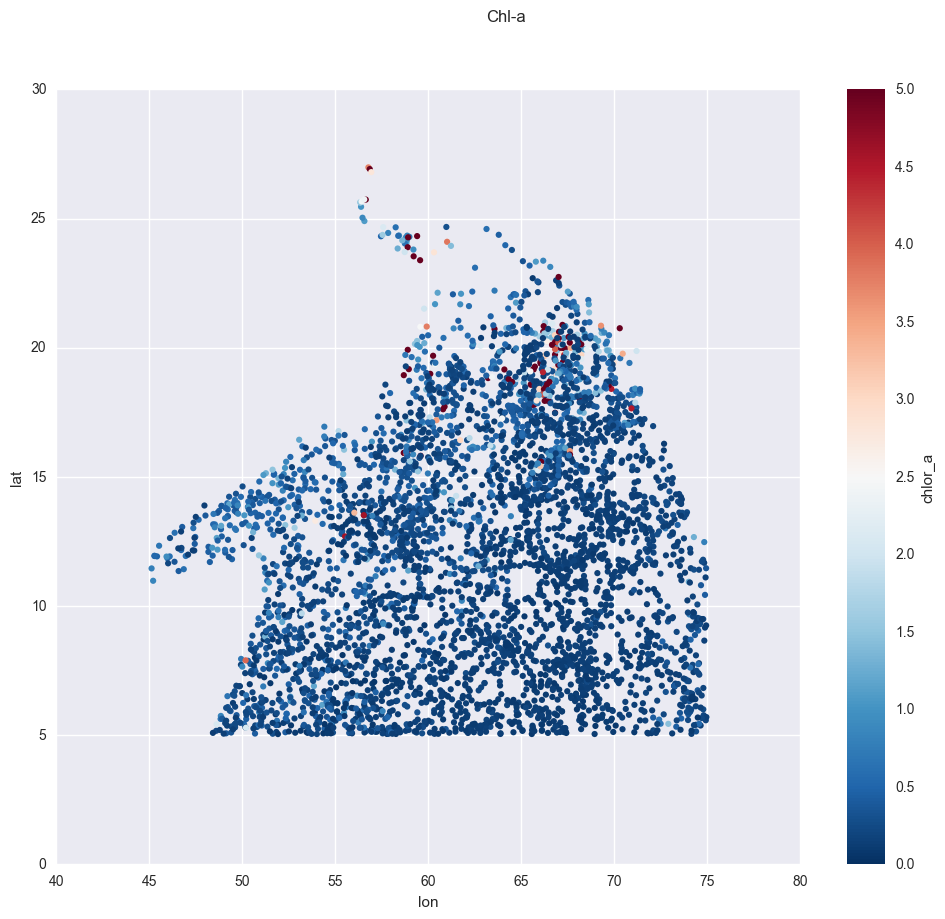

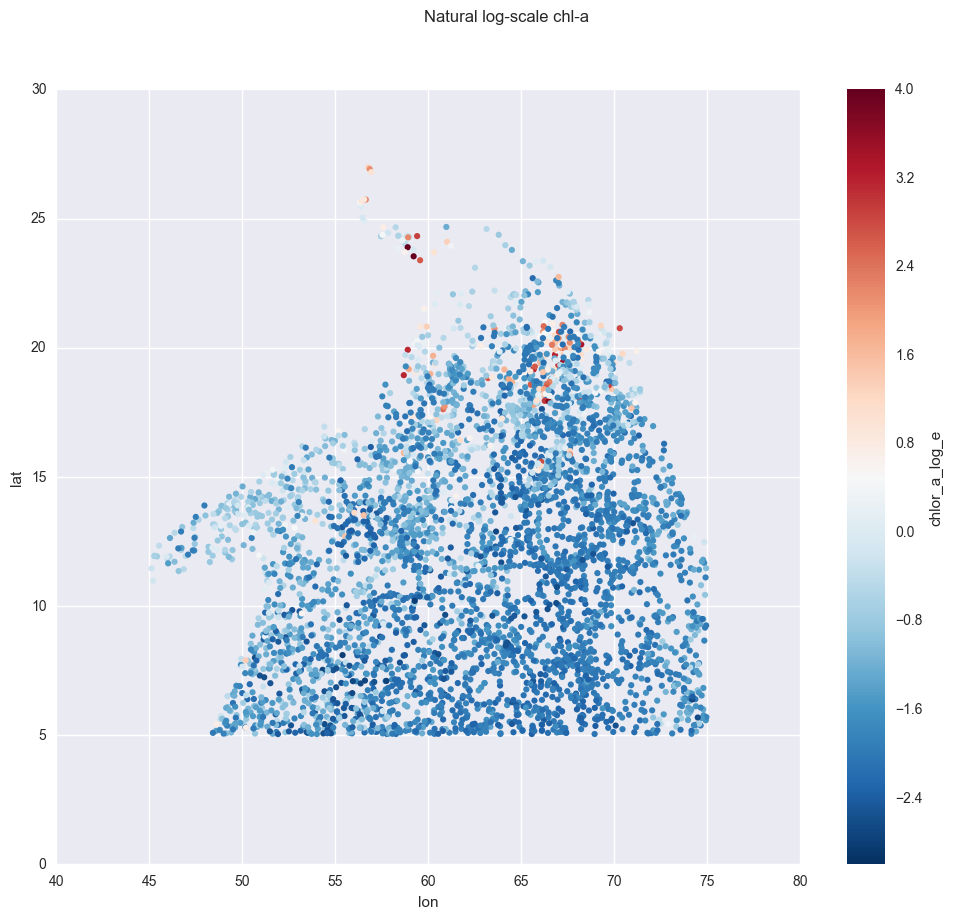

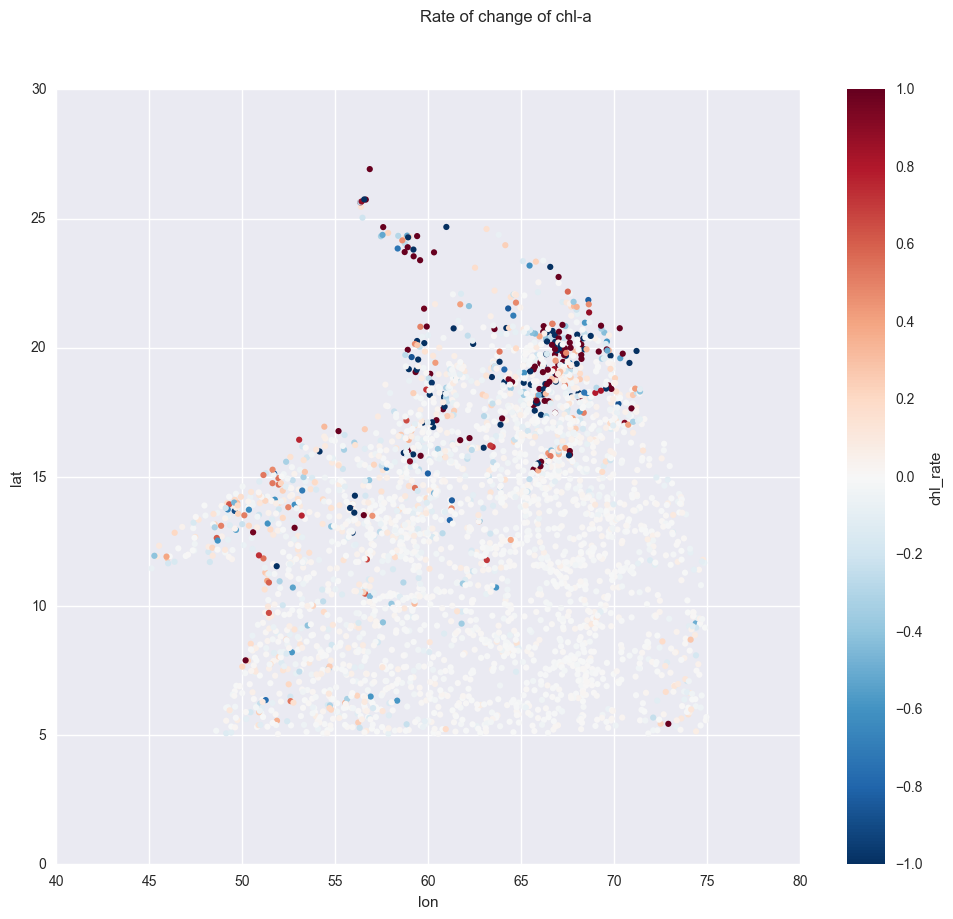

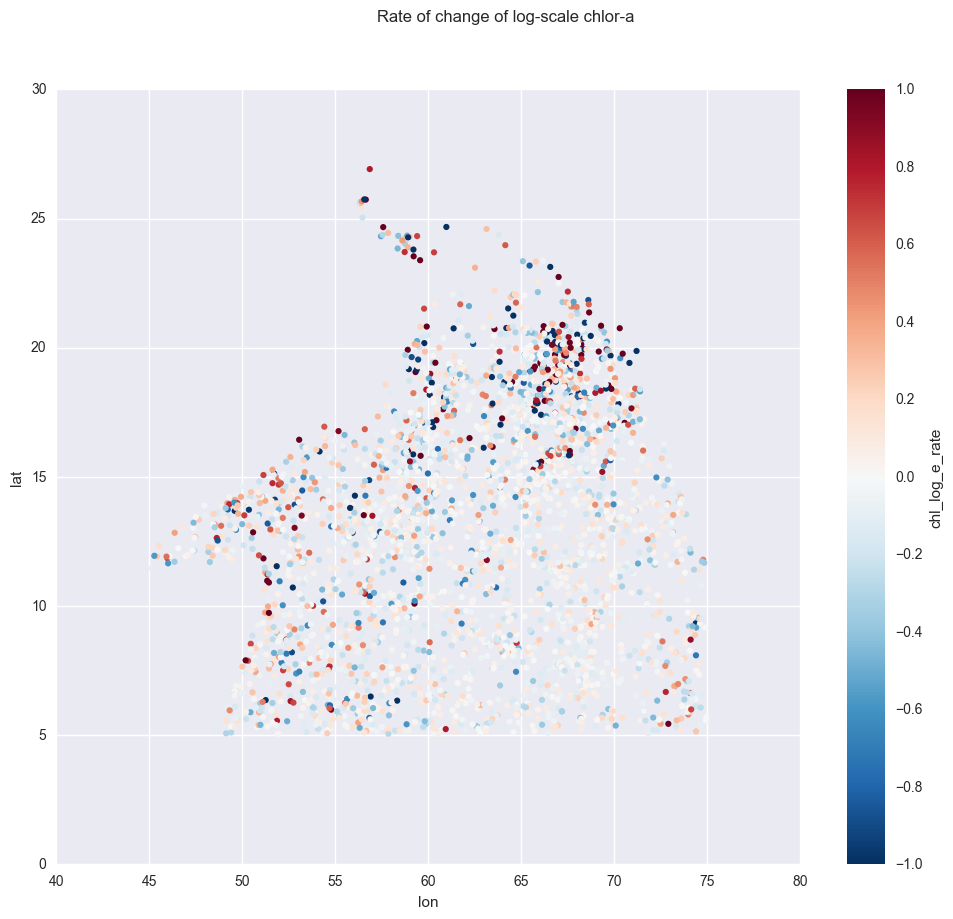


 ******* Select from November-01 to March-31 ******* 

shape of the selector (441336,)
all the data count during 'Nov-01 to Mar-31' is (1911,)
all the data count is (3131,)

 ******* histogram of the rate of change of chl-a ******* 


 ** summary of chl_rate ** 
 count    1911.000000
mean        0.016233
std         3.255408
min       -73.224130
25%        -0.042132
50%        -0.000838
75%         0.039028
max        43.617608
Name: chl_rate, dtype: float64


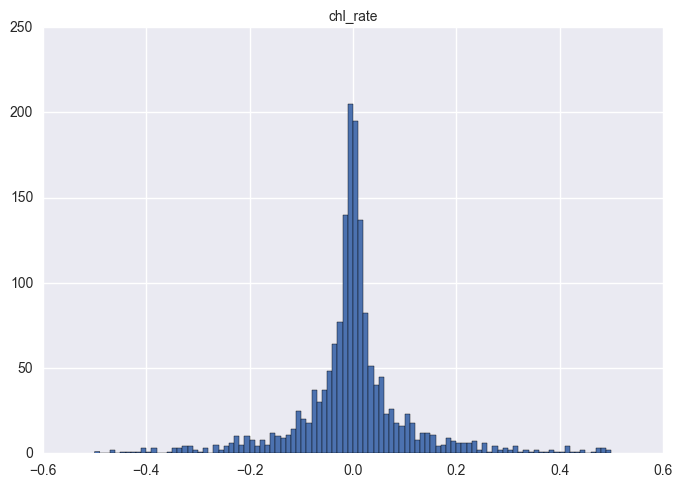


 ** summary of standardized chl_rate ** 
 count    1.911000e+03
mean    -1.042536e-17
std      1.000000e+00
min     -2.249806e+01
25%     -1.792853e-02
50%     -5.243988e-03
75%      7.002132e-03
max      1.339352e+01
Name: chl_rate, dtype: float64


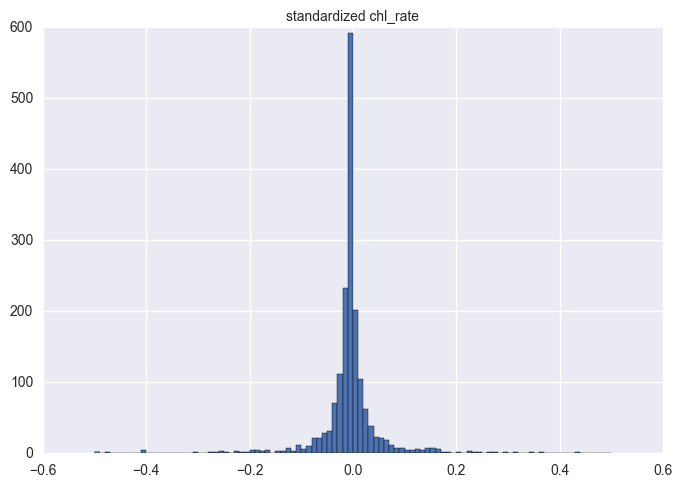


 ******* subplots of the rate of change of chl-a for different years ******* 


 count of data points for each year: 

(160,)
(130,)
(20,)
(121,)
(298,)
(311,)
(423,)
(133,)
(192,)
(82,)
(104,)
(96,)
(598,)
(316,)
(135,)


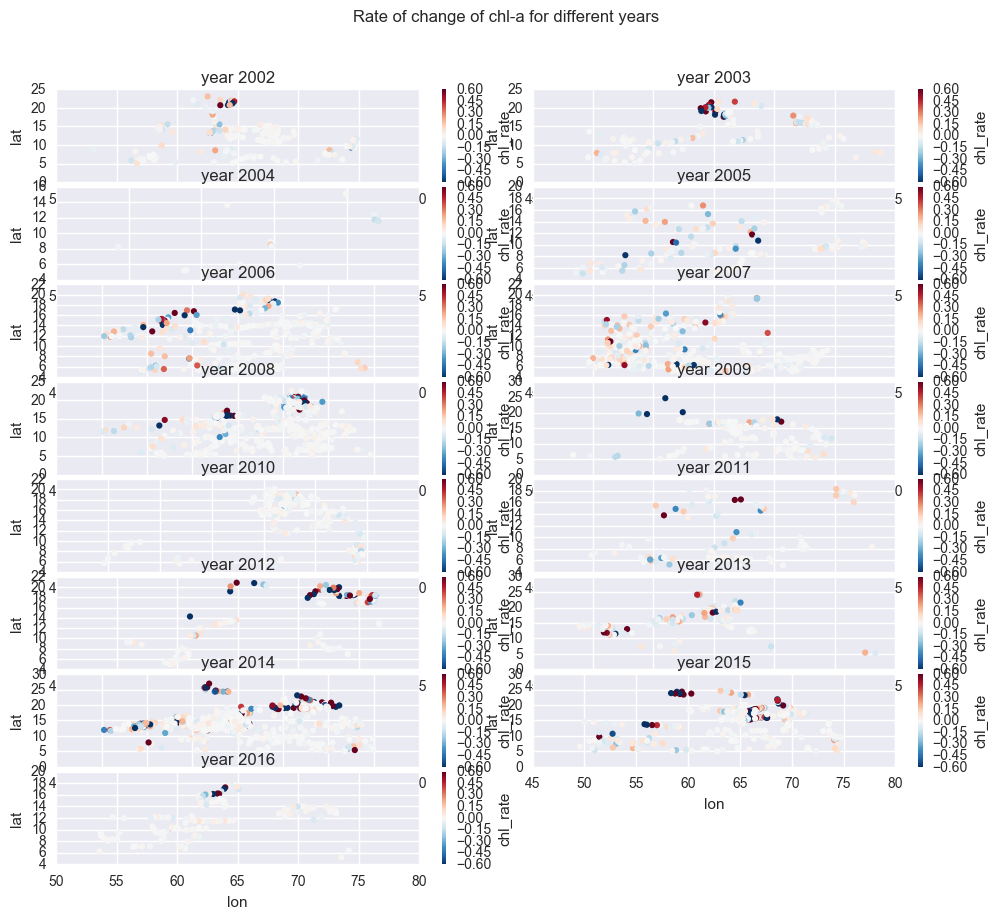


 count of data points during 'November-March' for each year: 

(167,)
(2,)
(32,)
(179,)
(131,)
(346,)
(81,)
(132,)
(21,)
(113,)
(0,)
(313,)
(259,)
(135,)


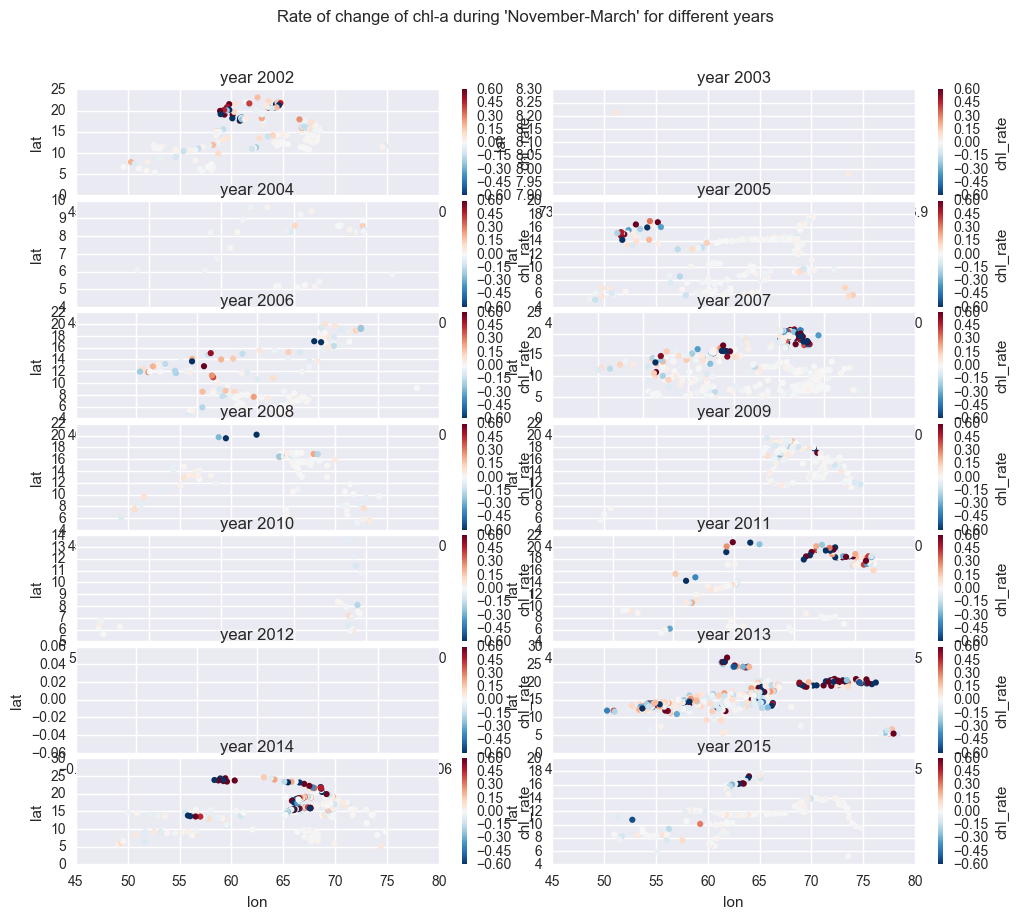


 ******* Reduce the Dataset to 'Nov-01 to Mar-31' ******* 

all the data count in [11-01, 03-31]  is  (1911,)

 ******* Nondimensionalize chl_rate and chl_log_e_rate ******* 


 **** Adding the 'rotated week no.'; Nov-1 is week no.1 **** 

the min and max of the week index is 1, 53 :

 ****** dataset with the week no. added ****** 
                id        lon   var_tmp        spd         vn        lat  \
time                                                                      
2002-11-01  11089  65.294333  0.003664  14.615583   7.076333  14.183417   
2002-11-01  34315  58.290167  0.003776  36.263583 -33.348417   6.691417   
2002-11-01  34710  63.120750  0.001866  13.900167  12.967750  16.815917   
2002-11-04  11089  65.079833  0.003887  10.934833   2.982250  14.289917   
2002-11-04  34315  58.092583  0.004223  37.136750 -27.707500   5.959583   
2002-11-04  34710  63.152417  0.001585  11.846417  11.040250  17.088667   
2002-11-04  34721  67.626250  0.001778  13.099250  -0.428083  12

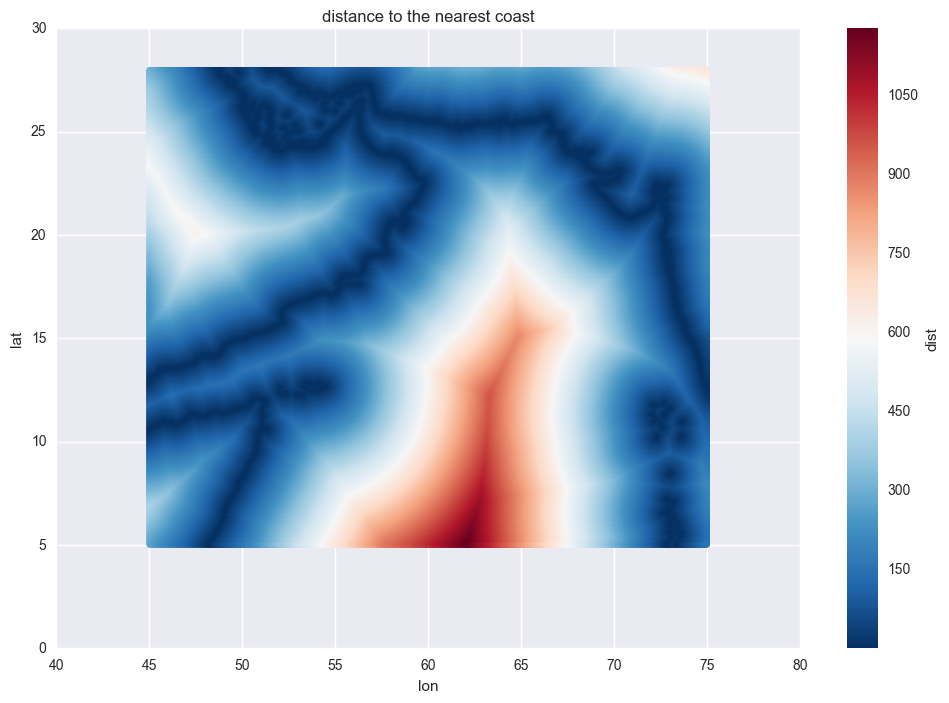


 ******** Interpolation of distance using (lat, lon) ******* 


 <xarray.DataArray 'dist' (points: 3315)>
array([ 505.49121451,  800.13533236,  507.84638564, ...,  436.16492463,
        701.88282428,  587.5804413 ])
Coordinates:
    time     (points) datetime64[ns] 2002-11-01 2002-11-01 2002-11-01 ...
    id       (points) int64 10206 11089 15707 34315 34710 34721 10206 11089 ...
    lon      (points) float64 67.49 65.29 68.32 58.29 63.12 67.56 67.32 ...
    lat      (points) float64 10.75 14.18 14.19 6.691 16.82 12.59 10.89 ...
  * points   (points) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...

 ******* Adding the 'distance to coast' ******* 

shape of the interpolation dateframe (3315, 5)
              dist       time     id        lon        lat
points                                                    
0       505.491215 2002-11-01  10206  67.486500  10.753083
1       800.135332 2002-11-01  11089  65.294333  14.183417
2       507.846386 2002-11-01  15707  68.315250  14

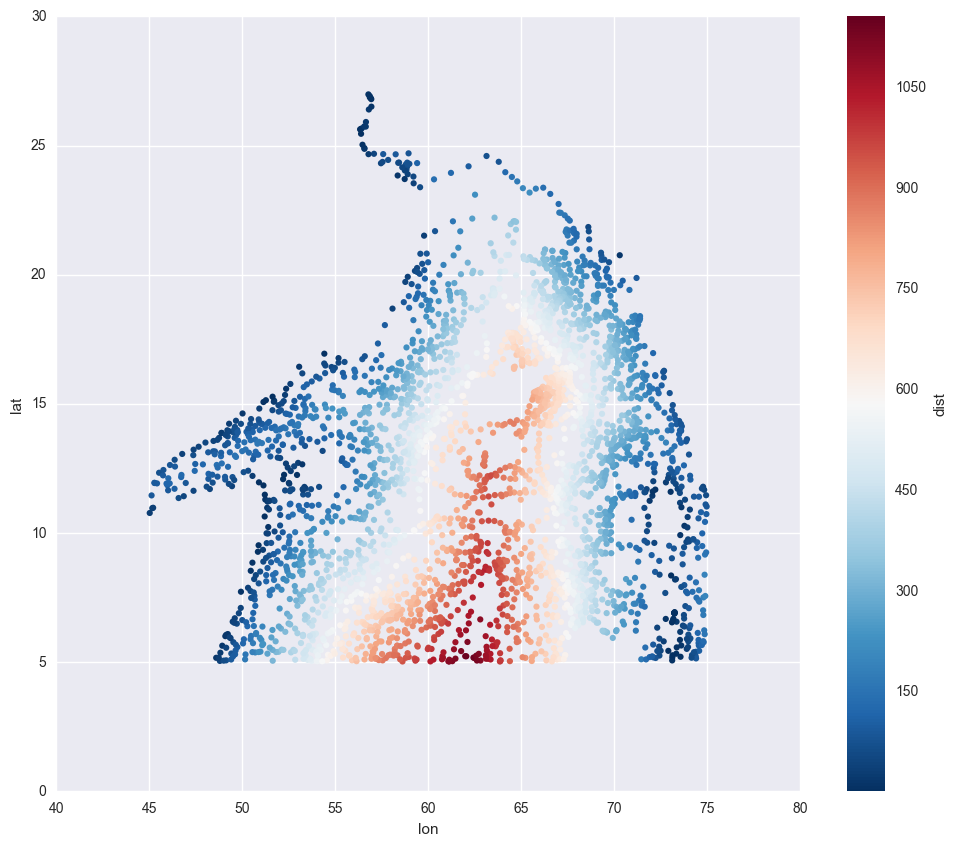


 ******* weekly plots and spatial plots on various rates of chl-a and log-scale chl-a ******* 


 ****** summary of chl_log_e_rate ****** 
 count    1911.000000
mean       -0.001539
std         0.180986
min        -1.163513
25%        -0.051485
50%        -0.001608
75%         0.048907
max         1.120796
Name: chl_log_e_rate, dtype: float64


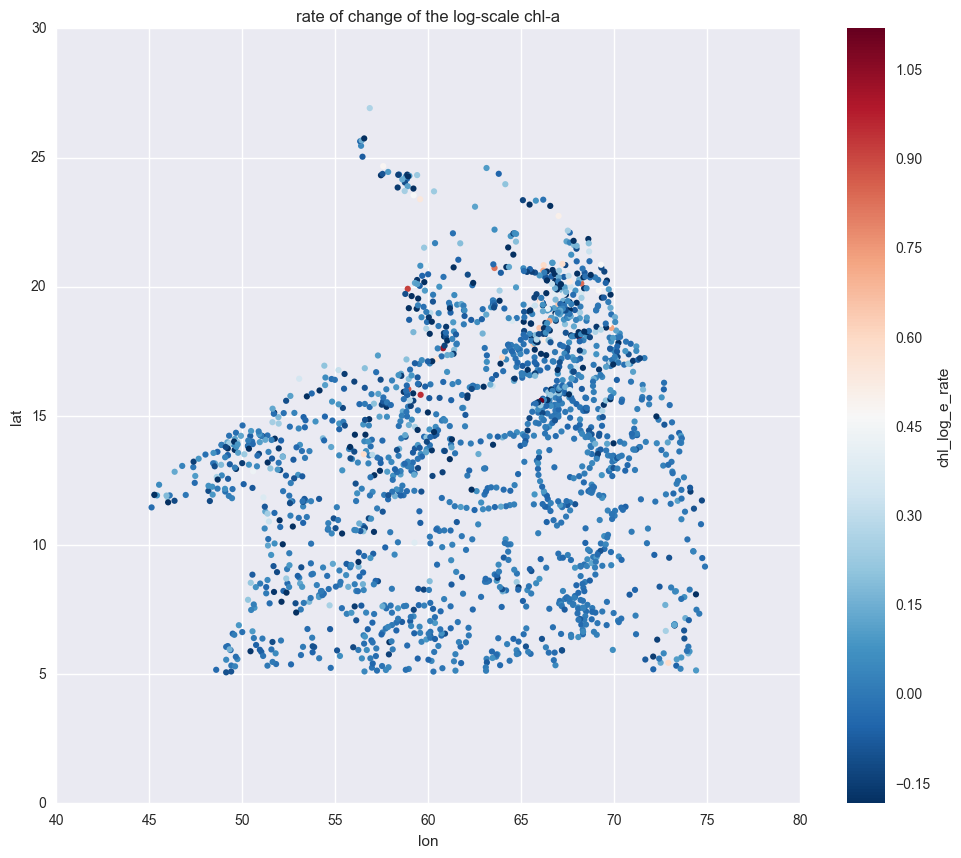


 ****** histogram of chl_log_e_rate ****** 
 count    1911.000000
mean       -0.001539
std         0.180986
min        -1.163513
25%        -0.051485
50%        -0.001608
75%         0.048907
max         1.120796
Name: chl_log_e_rate, dtype: float64


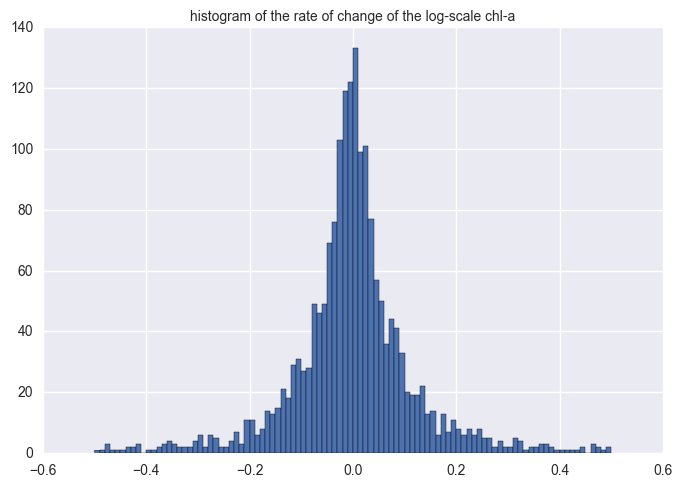


 ****** histogram of standardized chl_log_e_rate ****** 
 count    1.911000e+03
mean    -2.832202e-18
std      1.000000e+00
min     -6.420237e+00
25%     -2.759666e-01
50%     -3.777544e-04
75%      2.787320e-01
max      6.201226e+00
Name: chl_log_e_rate, dtype: float64


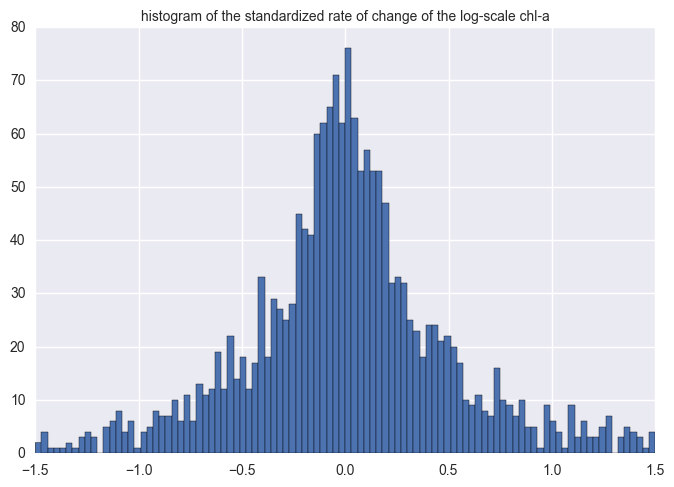


 check check check 
         time     id        lon      var_tmp        spd        vn        lat  \
0 2002-11-01   7574        NaN          NaN        NaN       NaN        NaN   
1 2002-11-01  10206  67.486500  1000.000000  10.972417  6.091083  10.753083   
2 2002-11-01  10208        NaN          NaN        NaN       NaN        NaN   
3 2002-11-01  11089  65.294333     0.003664  14.615583  7.076333  14.183417   
4 2002-11-01  15703        NaN          NaN        NaN       NaN        NaN   

          ve       temp   var_lon     ...      chlor_a_log_e  chl_rate  \
0        NaN        NaN       NaN     ...                NaN       NaN   
1  -7.563917        NaN  0.000629     ...          -2.030119 -0.001671   
2        NaN        NaN       NaN     ...                NaN       NaN   
3 -10.478917  29.029583  0.000109     ...          -2.057189  0.000628   
4        NaN        NaN       NaN     ...                NaN       NaN   

   chl_log_e_rate  chl_rate_stand  chl_log_e_rate_stand  c

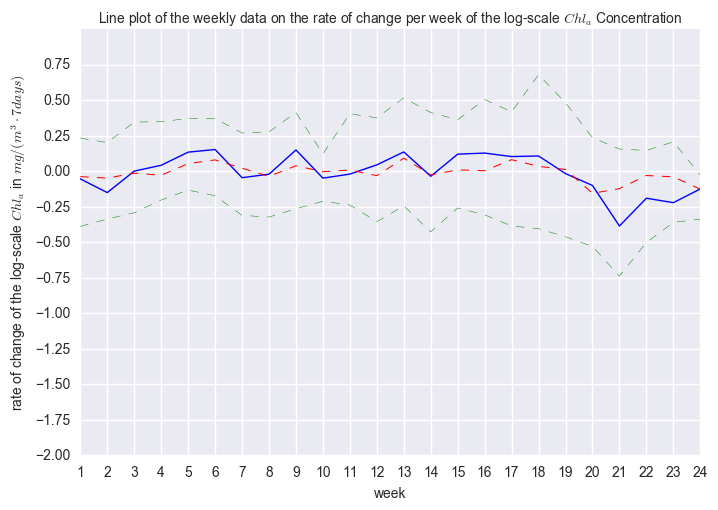

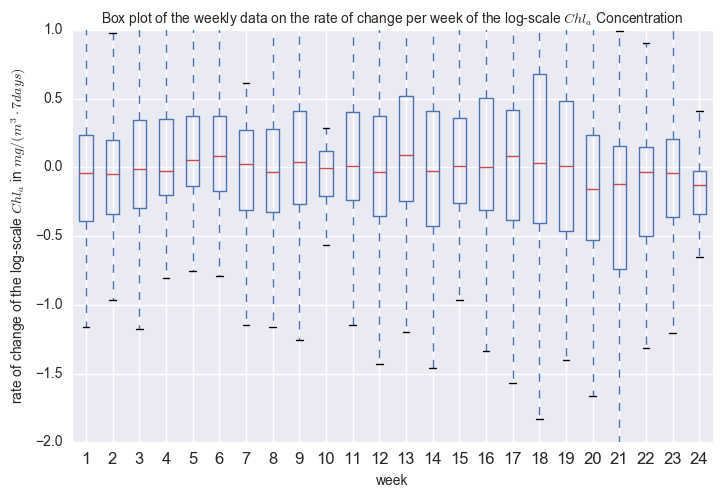


 ****** weekly plot of chl_rate_week ****** 



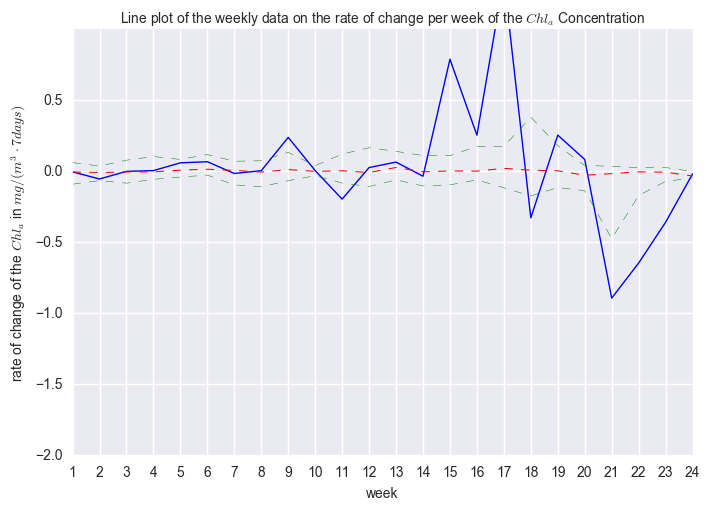

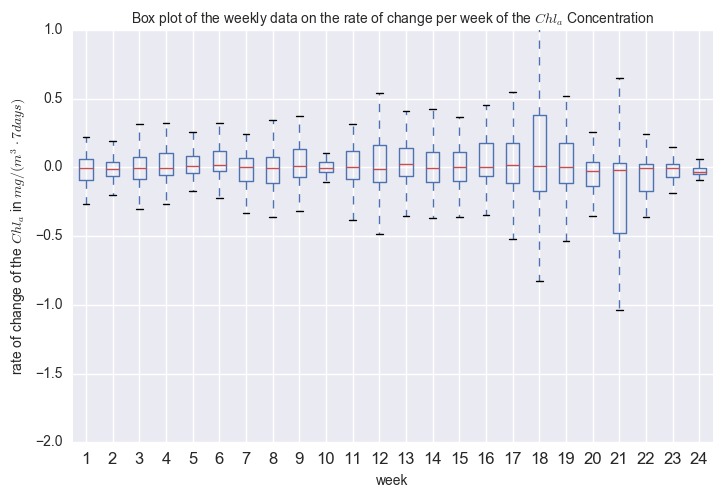


 ****** weekly plot of nondimensionalized daily chl_log_e_rate ****** 



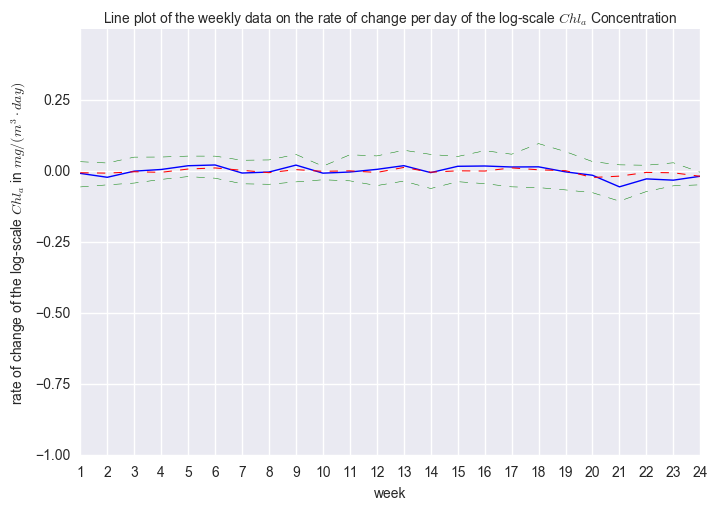

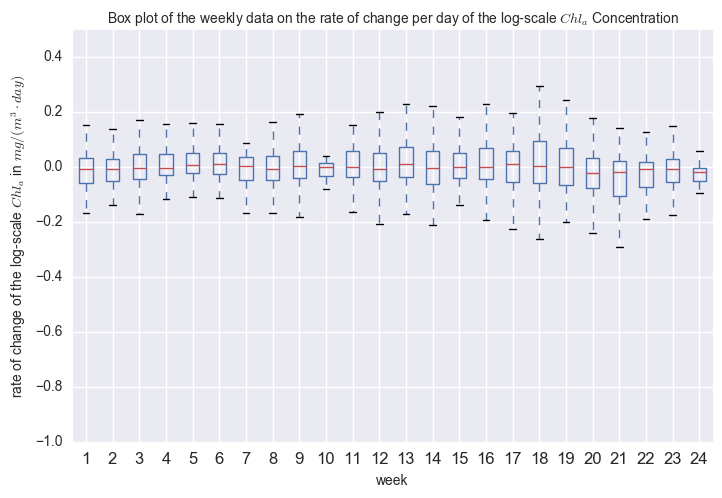


 ****** weekly plot of nondimensionalized daily chl_rate ****** 



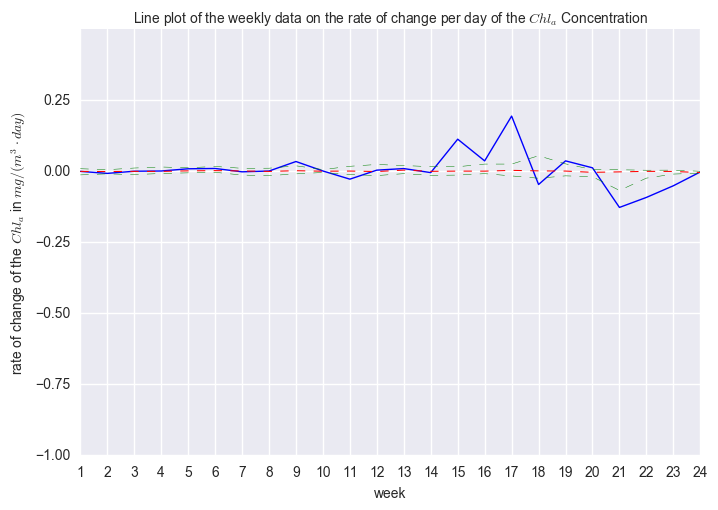

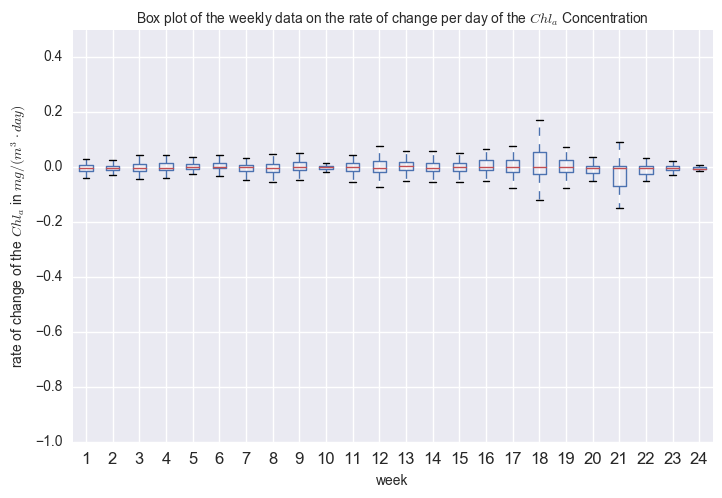


 ****** weekly plot of standardized nondimensionalized-daily chl_log_e_rate ****** 



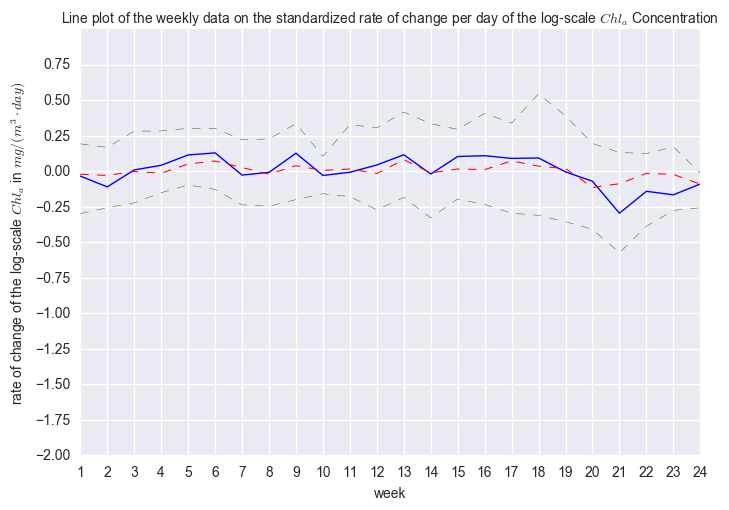

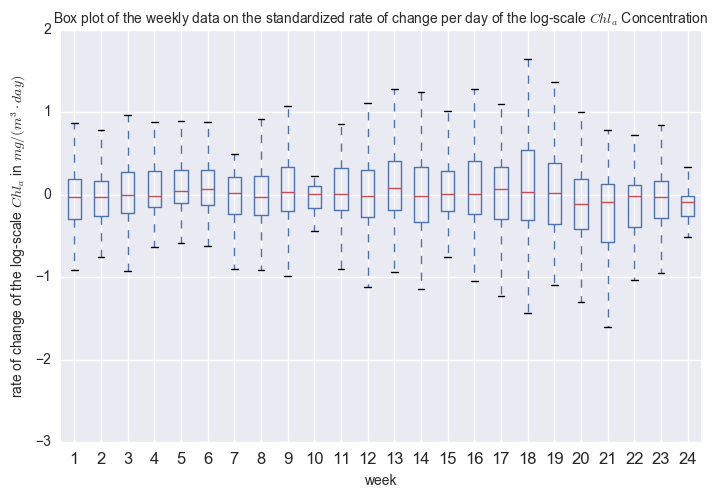


 ****** weekly plot of standardized nondimensionalized-daily chl_rate ****** 



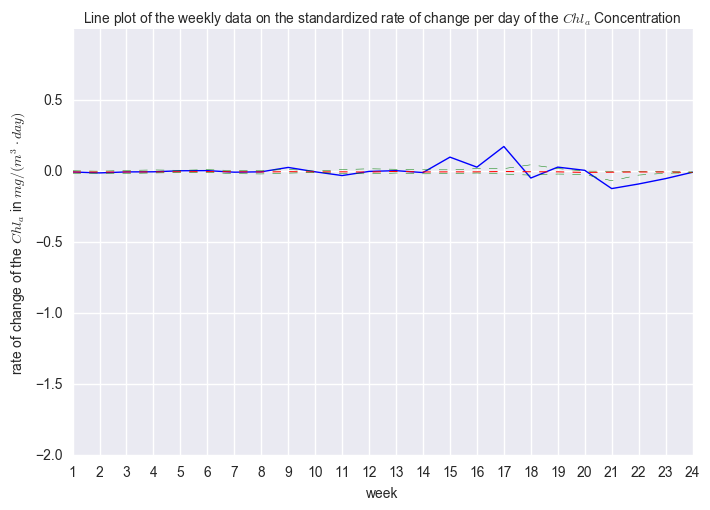

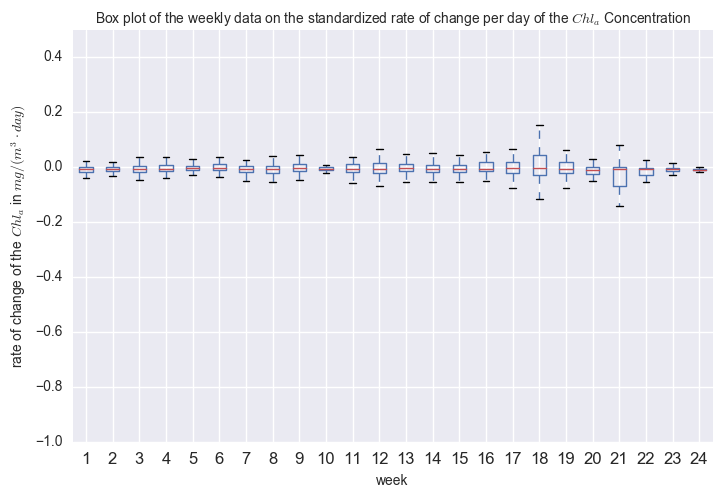


 ****** spatial plot of standardized nondimensionalized-daily chl_rate ****** 



 summary of the Chl_rate 
 count    274.000000
mean       0.001890
std        0.249189
min       -1.242791
25%       -0.076571
50%       -0.002849
75%        0.063123
max        2.258609
Name: chl_rate_week, dtype: float64


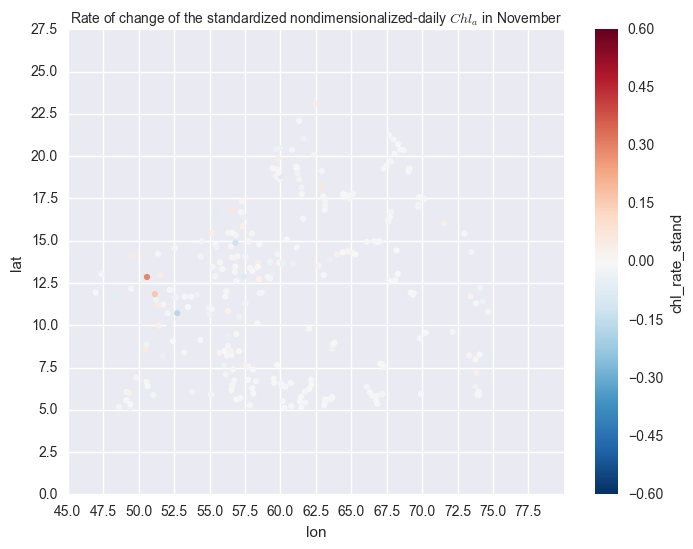



 summary of the Chl_rate 
 count    310.000000
mean       0.013894
std        1.643680
min      -16.620588
25%       -0.066585
50%        0.005762
75%        0.108244
max       18.069946
Name: chl_rate_week, dtype: float64


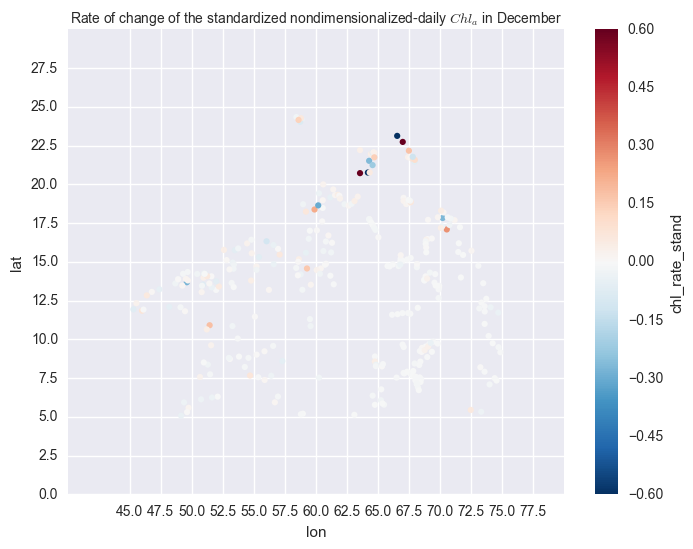



 summary of the Chl_rate 
 count    377.000000
mean       0.025943
std        2.868765
min      -41.807544
25%       -0.093175
50%        0.002516
75%        0.133545
max       32.845773
Name: chl_rate_week, dtype: float64


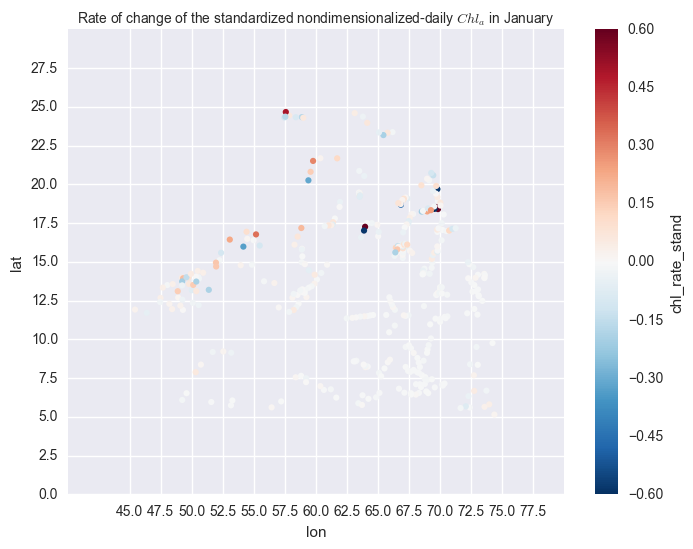



 summary of the Chl_rate 
 count    374.000000
mean       0.333561
std       14.615836
min     -170.856303
25%       -0.118255
50%        0.002559
75%        0.205046
max      101.774419
Name: chl_rate_week, dtype: float64


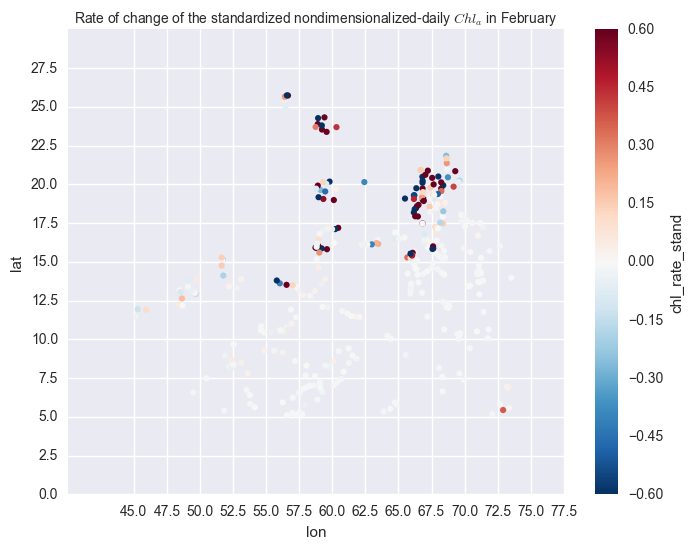



 summary of the Chl_rate 
 count    445.000000
mean      -0.170400
std        7.337284
min      -53.595121
25%       -0.127648
50%       -0.013397
75%        0.037246
max       54.051938
Name: chl_rate_week, dtype: float64


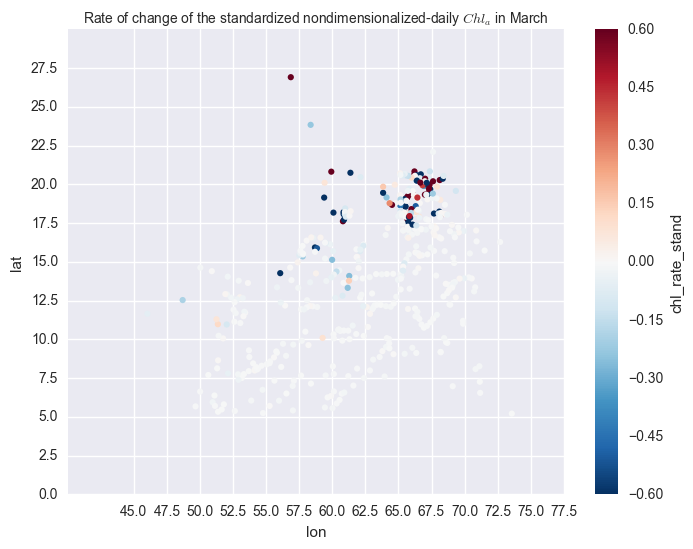


 ******* output data ******* 


 ****** generating the output file and validating the data file ****** 

all the data count during 'Nov-01 to Mar-31' is  (1911,)
         time     id        lon      var_tmp        spd         vn        lat  \
1  2002-11-01  10206  67.486500  1000.000000  10.972417   6.091083  10.753083   
3  2002-11-01  11089  65.294333     0.003664  14.615583   7.076333  14.183417   
5  2002-11-01  15707  68.315250  1000.000000  23.811083  -0.265333  14.188583   
19 2002-11-01  34315  58.290167     0.003776  36.263583 -33.348417   6.691417   
23 2002-11-01  34710  63.120750     0.001866  13.900167  12.967750  16.815917   

           ve       temp   var_lon     ...      chlor_a_log_e  chl_rate  \
1   -7.563917        NaN  0.000629     ...          -2.030119 -0.001671   
3  -10.478917  29.029583  0.000109     ...          -2.057189  0.000628   
5  -23.343750        NaN  0.000135     ...          -1.850621  0.003462   
19   6.626833  29.309167  0.000083     ...        

0

In [50]:
from tools import chl_rates  # del(chl_rates)
import importlib
importlib.reload(chl_rates)
importlib.reload(interpolate)
from tools import distance
importlib.reload(distance)

print("\n ******* The Multilinear Interpolation Approach for %dD resampling******* \n" % (freq))
floatsDF_Rate_interpolate = chl_rates.add_chl_rates(floatsDF_tmp, result_out4)

print("\n ******* Visualization on chl_rate and chl_log_e_rate ******* \n" )
chl_rates.spatial_hist_plots_chl_rate(floatsDF_Rate_interpolate)

print("\n ******* Reduce the Dataset to 'Nov-01 to Mar-31' ******* \n" )
floatsDF_Rate_NovMar = chl_rates.reduce_to_NovMar(floatsDF_Rate_interpolate)

print("\n ******* Nondimensionalize chl_rate and chl_log_e_rate ******* \n" )
floatsDF_Rate_NonDim_interpolate = chl_rates.nondimensionalize_chl_rate(floatsDF_Rate_NovMar, freq)
'''
# check #
aaa = floatsDF_9DRate_NonDim_interpolate
aaa.sort_values(['id','time']).dropna()      
print( (0.293062 - 0.804146)/9 )  # -0.056787 
print( (-1.227370- (-0.217974) )/9 )  # -0.112155 
'''


print("\n **** Adding the 'rotated week no.'; Nov-1 is week no.1 **** \n")
floatsDF_Rate_weekcol_interpolate = chl_rates.add_week(floatsDF_Rate_NonDim_interpolate) 

print("\n ******* Distance to coast added ******* \n")
print("\n ******* The Multilinear Interpolation Approach ******* \n" )
row_case_dist = pd.DataFrame(data={'time':list(floatsDF_Rate_weekcol_interpolate.time), 
                                   'lon':list(floatsDF_Rate_weekcol_interpolate.lon), 
                                   'lat':list(floatsDF_Rate_weekcol_interpolate.lat), 
                                   'id':list(floatsDF_Rate_weekcol_interpolate.id) } )
# process to drop nan in any of the columns [id], [lat], [lon], [time]
row_case_dist = row_case_dist.dropna(subset=['id', 'lat', 'lon', 'time'], how = 'any') # these four fields are critical
# print('\n after dropping nan \n', row_case_dist)
result_dist = interpolate.sel_points_multilinear_dist_lat_lon(row_case_dist, dims='points', col_name='dist') # interpolation

print("\n ******* Adding the 'distance to coast' ******* \n")
floatsDF_distance_interpolate = distance.add_distance_to_coast(floatsDF_Rate_weekcol_interpolate,result_dist)

print("\n ******* Visualization on 'distance to coast' ******* \n" )
distance.spatial_plots_distance(floatsDF_distance_interpolate)

print("\n ******* weekly plots and spatial plots on various rates of chl-a and log-scale chl-a ******* \n")
chl_rates.spatial_plots_chl_rate_weekly(floatsDF_distance_interpolate)


print("\n ******* output data ******* \n" )
# dropna only on subset {'chl_rate'}
chl_rates.output_chl_rates_dist(floatsDF_distance_interpolate, freq)

In [51]:
#### the original approach using the xarray.dataset.sel_points
#### to be removed from this notebook 
#### only for comparison purpose at this time
# a little test for the api in loops for the dataframe   
# check df.itertuples? it is faster and preserves the data format
'''
chl_ocx=[]
for row in floats_timeorder.itertuples():
    #print(row) # this line should not be executed!!!! takes a long time!!!!!
    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )
    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation
    chl_ocx.append(tmp)
floats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)
chl_ocx[0].to_series
'''

# this one line avoid the list above
# it took a really long time for 2D interpolation, it takes an hour
tmpAll = ds_resample.chlor_a.sel_points(time=list(floatsDFAll_resample_timeorder.time),lon=list(floatsDFAll_resample_timeorder.lon), lat=list(floatsDFAll_resample_timeorder.lat), method='nearest')
#print('the count of nan vaues in tmpAll is',tmpAll.to_series().isnull().sum())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


after editing the dataframe the nan values in 'chlor_a' is 438948


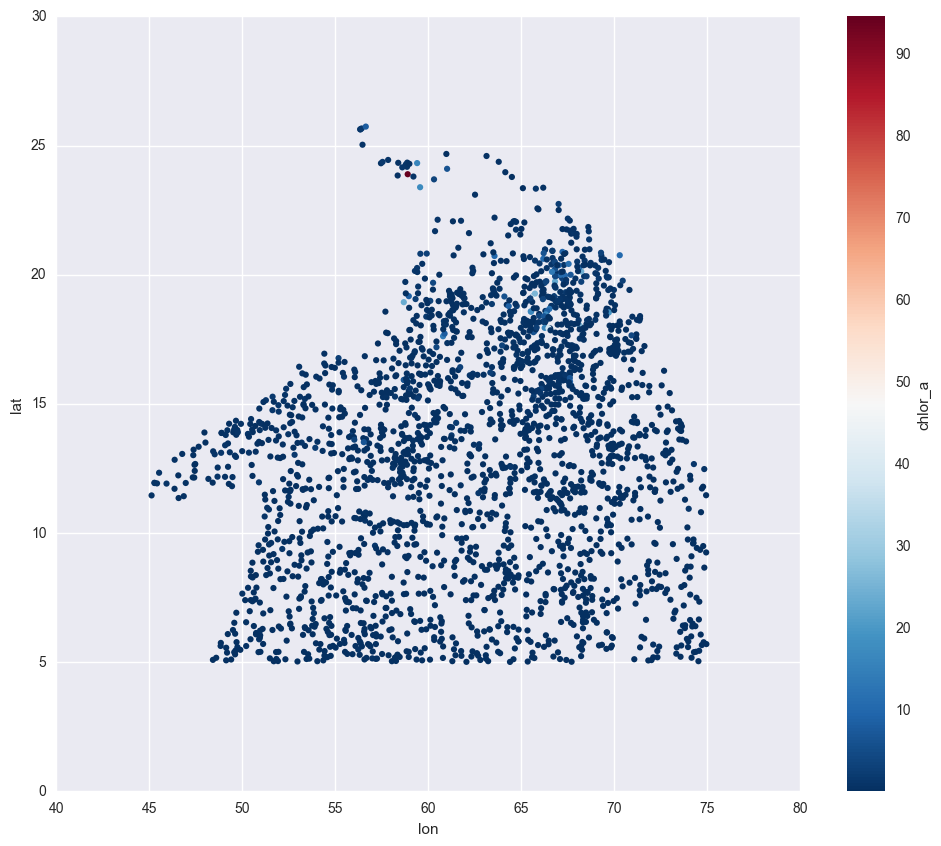

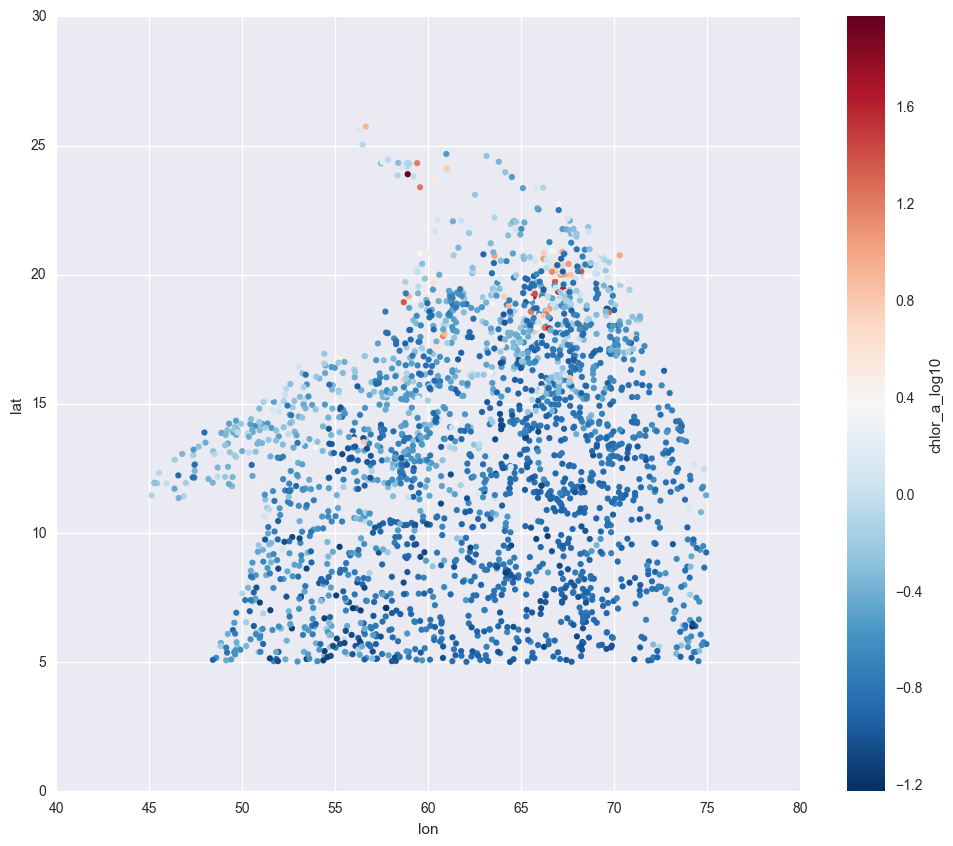

check the sum of the chlor_a before the merge -25.318965535610925
check the sum of the chlor_a after the merge -25.318965535610925


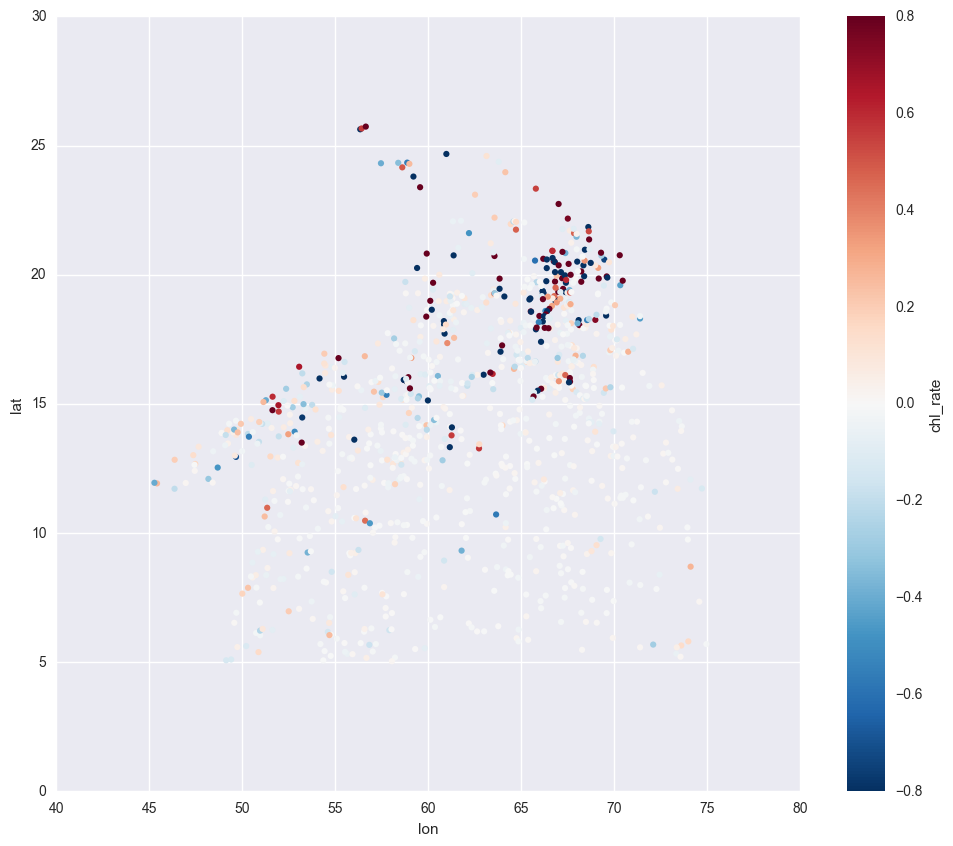

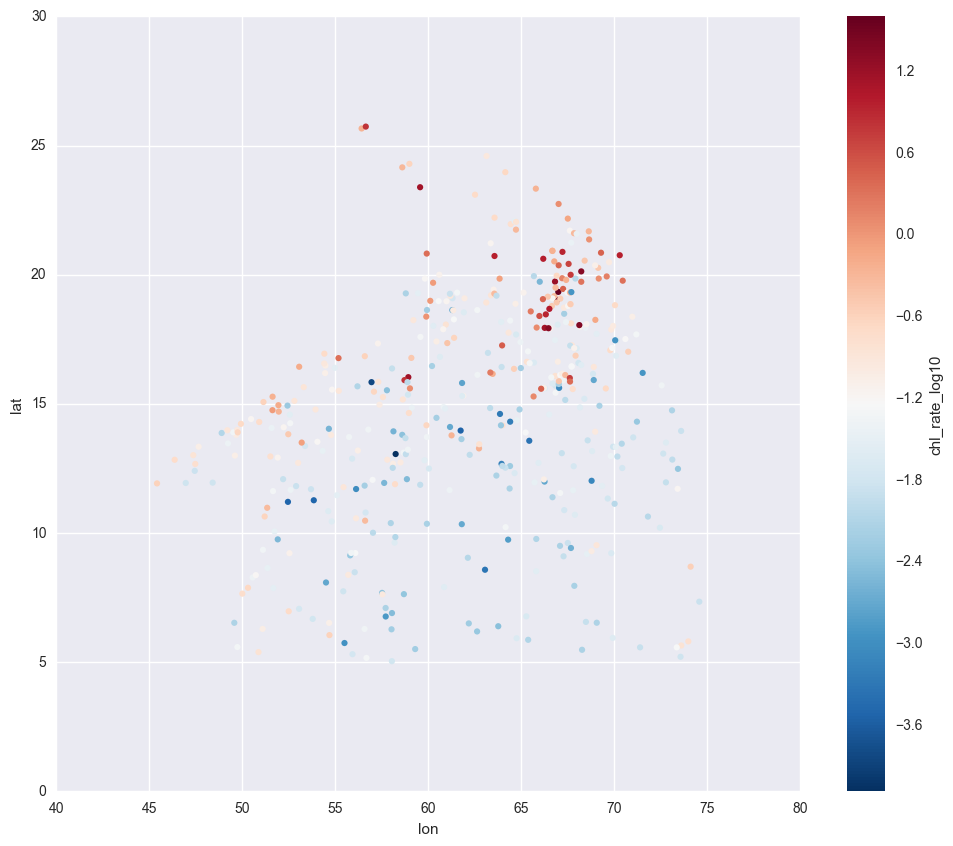

shape of the selector (441336,)
all the data count in [11-01, 03-31]  is (739,)
all the data count is (1018,)


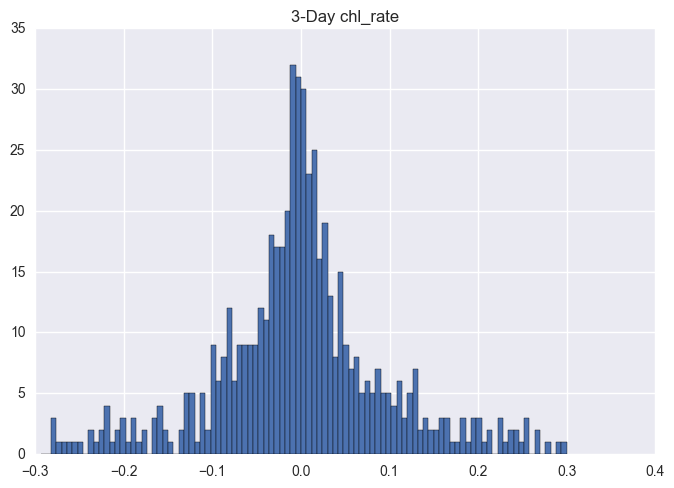

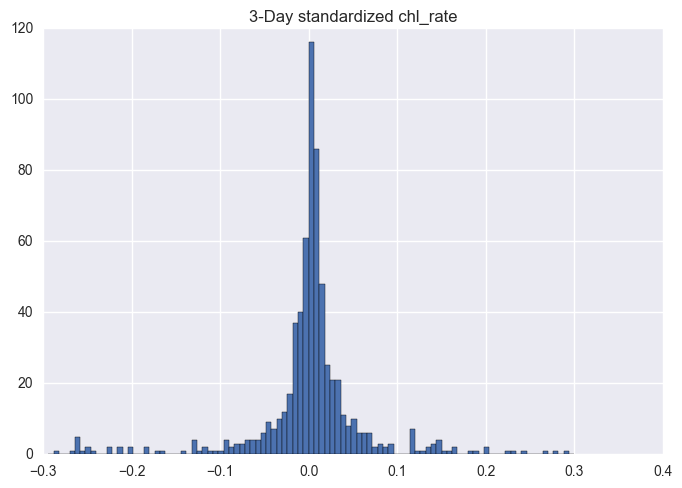

(47,)
(56,)
(3,)
(39,)
(92,)
(75,)
(123,)
(44,)
(50,)
(18,)
(38,)
(46,)
(227,)
(118,)
(40,)


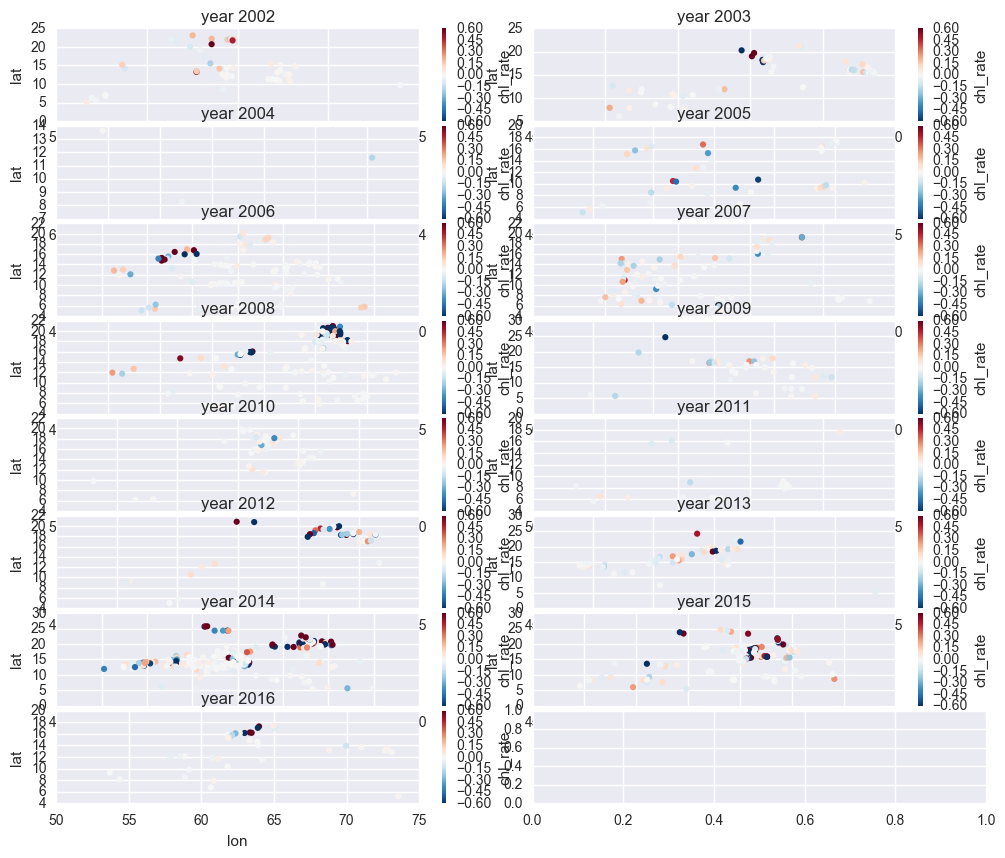

(76,)
(0,)
(5,)
(65,)
(38,)
(108,)
(35,)
(44,)
(3,)
(36,)
(0,)
(160,)
(119,)
(50,)


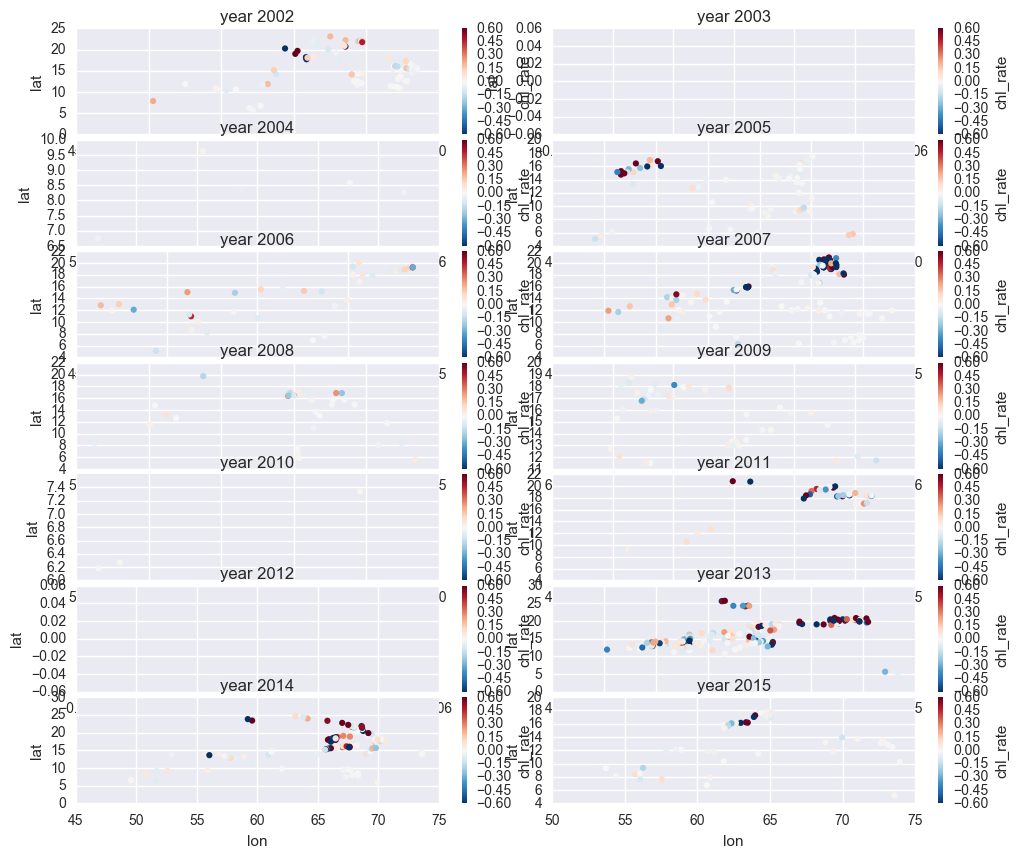


 ******  the next figure is for the period 'November-01 to March-01' ****** 

all the data count in [11-01, 03-31]  is  (739,)


id        time        lon      var_tmp        spd         vn  \
index                                                                    
10620  10206  2002-11-04  67.315250  1000.000000  11.224333   6.904000   
10648  34721  2002-11-04  67.626250     0.001778  13.099250  -0.428083   
10879  10206  2002-11-07  67.174083  1000.000000  10.497583   6.697417   
10881  11089  2002-11-07  64.770000     0.003795  16.718083   1.865000   
10883  15707  2002-11-07  67.346250  1000.000000  29.831500 -24.346083   

             lat         ve       temp   var_lon   var_lat   chlor_a  \
index                                                                  
10620  10.885583  -6.069667        NaN  0.001747  0.000579  0.145567   
10648  12.628833   6.291000  29.590750  0.000122  0.000064  0.129693   
10879  11.064250  -5.759333        NaN  0.000558  0.000221  0.129001   
10881  14.365167 -15.957833  28.995083  0.000151  0.000075  0.192121   
10883  13.640333 -15.104667        NaN  0.000132  0.000068  0.158005   

       chlor_a_log10  chl_rate  chl_rate_log10  
index                                           
10620      -0.836937  0.017202       -1.764421  
10648      -0.887083 -0.024359             NaN  
10879      -0.889407 -0.016566             NaN  
10881      -0.716425  0.033696       -1.472422  
10883      -0.801329 -0.008466             NaN

In [52]:
tmpAll # an array of xarray.DataArray
#print(tmpAll.dropna().shape)
tmpAll.to_series().dropna().shape  # (1631,) good values

# tmp.to_series() to transfer it from xarray dataset to series
floatsDFAll_resample_timeorder['chlor_a'] = pd.Series(np.array(tmpAll.to_series()), index=floatsDFAll_resample_timeorder.index)
print("after editing the dataframe the nan values in 'chlor_a' is", floatsDFAll_resample_timeorder.chlor_a.isnull().sum() )  # they should be the same values as above

# take a look at the data
floatsDFAll_resample_timeorder

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample_timeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a', cmap='RdBu_r', edgecolor='none', ax=ax)

def scale(x):
    logged = np.log10(x)
    return logged

#print(floatsAll_timeorder['chlor_a'].apply(scale))
floatsDFAll_resample_timeorder['chlor_a_log10'] = floatsDFAll_resample_timeorder['chlor_a'].apply(scale)
floatsDFAll_resample_timeorder
#print("after the transformation the nan values in 'chlor_a_log10' is", floatsAll_timeorder.chlor_a_log10.isnull().sum() )

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_resample_timeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAll_resample_timeorder.chlor_a.dropna().shape  # (1631,)
#floatsDFAll_resample_timeorder.chlor_a_log10.dropna().shape  # (1631,)
plt.show()

# take the diff of the chlor_a, and this has to be done in xarray
# transfer the dataframe into xarry dataset again
# take the difference
floatsDFAll_resample_timeorder

# unstack() will provide a 2d dataframe
# reset_index() will reset all the index as columns

# prepare the data in dataset and about to take the diff
tmp = xr.Dataset.from_dataframe(floatsDFAll_resample_timeorder.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
# take the diff on the chlor_a
chlor_a_rate = tmp.diff(dim='time',n=1).chlor_a.to_series().reset_index()
# make the column to a proper name
chlor_a_rate.rename(columns={'chlor_a':'chl_rate'}, inplace='True')
chlor_a_rate


# merge the two dataframes {floatsDFAll_XDtimeorder; chlor_a_rate} into one dataframe based on the index {id, time} and use the left method
floatsDFAllRate_resample_timeorder=pd.merge(floatsDFAll_resample_timeorder,chlor_a_rate, on=['time','id'], how = 'left')
floatsDFAllRate_resample_timeorder

# check 
print('check the sum of the chlor_a before the merge', chlor_a_rate.chl_rate.sum())
print('check the sum of the chlor_a after the merge',floatsDFAllRate_resample_timeorder.chl_rate.sum())


# visualize the chlorophyll rate, it is *better* to visualize at this scale
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_resample_timeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.8, vmax=0.8, edgecolor='none', ax=ax)
plt.show()

# visualize the chlorophyll rate on the log scale
floatsDFAllRate_resample_timeorder['chl_rate_log10'] = floatsDFAllRate_resample_timeorder['chl_rate'].apply(scale)
floatsDFAllRate_resample_timeorder
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_resample_timeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
#floatsDFAllRate_9Dtimeorder.chl_rate.dropna().shape   # (1008,) data points
floatsDFAllRate_resample_timeorder.chl_rate_log10.dropna().shape   # (417,)data points..... notice, chl_rate can be negative, so do not take log10
plt.show()

pd.to_datetime(floatsDFAllRate_resample_timeorder.time)
type(pd.to_datetime(floatsDFAllRate_resample_timeorder.time))
ts = pd.Series(0, index=pd.to_datetime(floatsDFAllRate_resample_timeorder.time) ) # creat a target time series for masking purpose

# take the month out
month = ts.index.month 
# month.shape # a check on the shape of the month.
selector = ((11==month) | (12==month) | (1==month) | (2==month) | (3==month) )  
selector
print('shape of the selector', selector.shape)

print('all the data count in [11-01, 03-31]  is', floatsDFAllRate_resample_timeorder[selector].chl_rate.dropna().shape) # total (672,)
print('all the data count is', floatsDFAllRate_resample_timeorder.chl_rate.dropna().shape )   # total (1008,)

# histogram for non standarized data
axfloat = floatsDFAllRate_resample_timeorder[selector].chl_rate.dropna().hist(bins=100,range=[-0.3,0.3])
axfloat.set_title(str(freq)+'-Day chl_rate')
plt.show()

# standarized series
ts = floatsDFAllRate_resample_timeorder[selector].chl_rate.dropna()
ts_standardized = (ts - ts.mean())/ts.std()
axts = ts_standardized.hist(bins=100,range=[-0.3,0.3])
axts.set_title(str(freq)+'-Day standardized chl_rate')
plt.show()

# all the data
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2017), axes.flat) :
    tmpyear = floatsDFAllRate_resample_timeorder[ (floatsDFAllRate_resample_timeorder.time > str(i))  & (floatsDFAllRate_resample_timeorder.time < str(i+1)) ] # if year i
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)   # total is 1001
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r',vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)     
    
# remove the extra figure
ax = plt.subplot(8,2,16)
plt.show()
fig.delaxes(ax)

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2016), axes.flat) :
    tmpyear = floatsDFAllRate_resample_timeorder[ (floatsDFAllRate_resample_timeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_resample_timeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)  # the total is 672
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)  
plt.show()    
    
    
print("\n ******  the next figure is for the period 'November-01 to March-01' ****** \n")
    
# let's output the data as a csv or hdf file to disk to save the experiment time
df_list = []
for i in range(2002,2017) :
    tmpyear = floatsDFAllRate_resample_timeorder[ (floatsDFAllRate_resample_timeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_resample_timeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
print('all the data count in [11-01, 03-31]  is ', df_tmp.chl_rate.dropna().shape) # again, the total is (692,)
df_chl_out_modisa = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_XD.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
df_chl_out_modisa.head()

df_chl_out_modisa.index.name = 'index'  # make it specific for the index name

outfile = 'df_chl_out_' + str(freq) + 'D' + '_modisa.csv'
# CSV CSV CSV CSV with specfic index
df_chl_out_modisa.to_csv(outfile, sep=',', index_label = 'index')

# load CSV output
test = pd.read_csv(outfile, index_col='index')
test.head()